# import

In [4]:
import logging
import json
import time
import random
import os
import concurrent.futures
from pathlib import Path
from tqdm import tqdm
import torch
from sentence_transformers import SentenceTransformer

# 로깅 설정
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class MedicalVectorStoreE5:
    """
    intfloat/multilingual-e5-large 모델을 사용한 의료 데이터 벡터 스토어 구축 클래스 
    - Gemini와 동일한 데이터 구조 사용
    """
    def __init__(self, data_path="./medical_data", vector_store_path="./vector_stores", use_gpu=True):
        """
        초기화 함수
        
        Args:
            data_path: 의료 데이터가 저장된 경로
            vector_store_path: 벡터 스토어를 저장할 경로
            use_gpu: GPU 사용 여부
        """
        self.data_path = Path(data_path)
        self.vector_store_path = Path(vector_store_path)
        
        # 기본 디렉토리 생성
        self.data_path.mkdir(parents=True, exist_ok=True)
        self.vector_store_path.mkdir(parents=True, exist_ok=True)

        # GPU 사용 여부 확인
        self.device = "cuda" if use_gpu and torch.cuda.is_available() else "cpu"
        logger.info(f"Using device: {self.device}")

        # GPU 메모리 정보 출력
        if torch.cuda.is_available():
            gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
            logger.info(f"GPU 메모리: {gpu_memory:.1f} GB")

        # multilingual-e5-large 모델 로드
        logger.info("multilingual-e5-large 모델 로드 중...")
        self.embedding_model = SentenceTransformer(
            'intfloat/multilingual-e5-large',
            device=self.device
        )
        logger.info("임베딩 모델 로드 완료")

        # LangChain 호환 임베딩 클래스
        class E5Embeddings:
            def __init__(self, model, device):
                self.model = model
                self.device = device
            
            def embed_documents(self, texts):
                """문서 임베딩 (배치 처리) - 대용량 데이터 최적화"""
                # 대용량 데이터를 위한 동적 배치 크기 조정
                batch_size = self._get_optimal_batch_size(len(texts))
                
                # E5 모델은 문서 검색을 위해 'passage: ' 접두사 사용
                prefixed_texts = [f"passage: {text}" for text in texts]
                embeddings = self.model.encode(
                    prefixed_texts,
                    batch_size=batch_size,
                    show_progress_bar=False,
                    convert_to_tensor=False,
                    normalize_embeddings=True  # 정규화
                )
                return embeddings.tolist()
            
            def embed_query(self, text):
                """쿼리 임베딩"""
                # E5 모델은 쿼리를 위해 'query: ' 접두사 사용
                prefixed_text = f"query: {text}"
                embedding = self.model.encode(
                    [prefixed_text],
                    show_progress_bar=False,
                    convert_to_tensor=False,
                    normalize_embeddings=True
                )
                return embedding[0].tolist()
            
            def _get_optimal_batch_size(self, text_count):
                """텍스트 수와 GPU 메모리에 따른 최적 배치 크기 결정"""
                if not torch.cuda.is_available():
                    return 4
                
                gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1024**3
                
                if gpu_memory_gb >= 16:
                    return min(32, text_count)
                elif gpu_memory_gb >= 8:
                    return min(16, text_count)
                else:
                    return min(8, text_count)
            
            def __call__(self, text):
                """FAISS에서 직접 호출되는 경우를 위한 메서드"""
                if isinstance(text, list):
                    return self.embed_documents(text)
                else:
                    return self.embed_query(text)
        
        # 임베딩 인스턴스 생성
        self.embeddings = E5Embeddings(self.embedding_model, self.device)

        from langchain.text_splitter import RecursiveCharacterTextSplitter

        # 문서 분할기 설정 (E5 모델에 적합하게 조정)
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=512,  # E5 모델의 최대 토큰 길이 고려
            chunk_overlap=50,
            separators=["\n\n", "\n", ". ", " ", ""],
            length_function=len
        )

    def _embed_documents_batch(self, texts, batch_size=None):
        """
        배치 단위로 문서 임베딩 생성 - 대용량 데이터 최적화
        """
        try:
            # 동적 배치 크기 결정
            if batch_size is None:
                batch_size = self._get_dynamic_batch_size(len(texts))
            
            logger.info(f"임베딩 생성 중 (텍스트 수: {len(texts)}, 배치 크기: {batch_size})")
            
            # E5 모델용 접두사 추가
            prefixed_texts = [f"passage: {text}" for text in texts]
            
            # 임베딩 생성
            embeddings = self.embedding_model.encode(
                prefixed_texts,
                batch_size=batch_size,
                show_progress_bar=True,
                convert_to_tensor=False,
                normalize_embeddings=True
            )
            
            logger.info(f"임베딩 생성 완료: {len(embeddings)}개, 차원: {len(embeddings[0])}")
            return embeddings.tolist()
            
        except Exception as e:
            logger.error(f"임베딩 생성 중 오류 발생: {e}")
            raise

    def _get_dynamic_batch_size(self, text_count):
        """동적 배치 크기 결정 - GPU 메모리와 데이터 크기를 고려"""
        if not torch.cuda.is_available():
            return min(8, text_count)
        
        # GPU 메모리 정보
        gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1024**3
        
        # 현재 GPU 메모리 사용량 확인
        allocated_memory = torch.cuda.memory_allocated() / 1024**3
        free_memory = gpu_memory_gb - allocated_memory
        
        logger.info(f"GPU 메모리 상태: 전체 {gpu_memory_gb:.1f}GB, 사용 중 {allocated_memory:.1f}GB, 여유 {free_memory:.1f}GB")
        
        # 여유 메모리에 따른 배치 크기 조정
        if free_memory >= 12:
            batch_size = min(64, text_count)
        elif free_memory >= 8:
            batch_size = min(32, text_count)
        elif free_memory >= 4:
            batch_size = min(16, text_count)
        else:
            batch_size = min(8, text_count)
        
        logger.info(f"동적 배치 크기 결정: {batch_size}")
        return batch_size

    def load_medical_data(self, file_pattern="*_patients.json", max_workers=None):
        """
        의료 데이터 로드 - 병렬 처리 최적화
        """
        data_files = list(self.data_path.glob(file_pattern))

        if not data_files:
            logger.warning(f"No files matching {file_pattern} found in {self.data_path}")
            return []

        logger.info(f"발견된 파일 수: {len(data_files)}")

        # 최적 워커 수 결정
        if max_workers is None:
            max_workers = min(len(data_files), os.cpu_count())
        
        logger.info(f"병렬 처리 워커 수: {max_workers}")

        # 병렬 처리로 여러 파일 동시 로드
        documents = []
        total_patients = 0

        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
            future_to_file = {
                executor.submit(self._load_single_file, file_path): file_path
                for file_path in data_files
            }

            for future in tqdm(concurrent.futures.as_completed(future_to_file),
                               total=len(future_to_file),
                               desc="파일 로딩 중"):
                file_path = future_to_file[future]
                try:
                    file_docs, patient_count = future.result()
                    if file_docs:
                        documents.extend(file_docs)
                        total_patients += patient_count
                        logger.info(f"{file_path.name}: {patient_count}명 환자, {len(file_docs)}개 문서")
                except Exception as e:
                    logger.error(f"파일 처리 실패 {file_path}: {e}")

        logger.info(f"전체 로드 완료: {total_patients}명 환자, {len(documents)}개 문서")
        return documents

    def _load_single_file(self, file_path):
        """
        단일 파일 로드 (병렬 처리용) - 전체 데이터 사용
        """
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                patients = json.load(f)

            department = file_path.stem.replace("_patients", "")
            
            # ✅ 전체 데이터 사용 - 제한 코드 완전 제거
            logger.info(f"{department} 과에서 전체 {len(patients)}명 환자 로딩 중")

            # 각 환자 정보를 문서로 변환
            docs = []
            for patient in patients:
                docs.extend(self._convert_patient_to_documents(patient, department))

            return docs, len(patients)

        except Exception as e:
            logger.error(f"파일 로드 오류 {file_path}: {e}")
            return [], 0

    def _convert_patient_to_documents(self, patient, department):
        """
        환자 정보를 여러 개의 문서로 변환 - Gemini와 동일한 구조 사용
        """
        from langchain.schema import Document

        documents = []

        # 환자 기본 정보 문서
        basic_info = f"""
        환자 ID: {patient['id']}
        이름: {patient['name']}
        성별: {patient['gender']}
        나이: {patient['age']}
        생년월일: {patient['birthdate']}
        혈액형: {patient.get('blood_type', '정보 없음')}
        키: {patient.get('height', '정보 없음')} cm
        체중: {patient.get('weight', '정보 없음')} kg
        BMI: {patient.get('bmi', '정보 없음')}
        주소: {patient.get('address', '정보 없음')}
        전화번호: {patient.get('phone', '정보 없음')}
        보험: {patient.get('insurance', '정보 없음')}
        진료과: {department}
        """

        if patient.get('allergies'):
            basic_info += f"\n알레르기: {', '.join(patient['allergies'])}"

        if patient.get('smoking'):
            basic_info += f"\n흡연: {patient['smoking']['status']}"
            if patient['smoking'].get('details'):
                basic_info += f" ({patient['smoking']['details']})"

        if patient.get('alcohol'):
            basic_info += f"\n음주: {patient['alcohol']['status']}"
            if patient['alcohol'].get('details'):
                basic_info += f" ({patient['alcohol']['details']})"

        documents.append(Document(
            page_content=basic_info.strip(),
            metadata={
                "patient_id": patient['id'],
                "name": patient['name'],
                "gender": patient['gender'],
                "age": patient['age'],
                "department": department,
                "document_type": "basic_info"
            }
        ))

        # 진단 정보 문서
        if patient.get('diagnoses'):
            for i, diagnosis in enumerate(patient['diagnoses']):
                diagnosis_doc = f"""
                환자 ID: {patient['id']}
                이름: {patient['name']}
                성별: {patient['gender']}
                나이: {patient['age']}

                [진단 정보 {i+1}]
                진단명: {diagnosis['name']}
                ICD10 코드: {diagnosis.get('icd10', '정보 없음')}
                진단일: {diagnosis.get('date', '정보 없음')}
                진단 의사: {diagnosis.get('doctor', '정보 없음')} (ID: {diagnosis.get('doctor_id', '정보 없음')})
                확신도: {diagnosis.get('confidence', '정보 없음')}
                상태: {diagnosis.get('status', '정보 없음')}
                중증도: {diagnosis.get('severity', '정보 없음')}
                메모: {diagnosis.get('memo', '정보 없음')}
                증상: {', '.join(diagnosis.get('symptoms', ['정보 없음']))}
                """

                documents.append(Document(
                    page_content=diagnosis_doc.strip(),
                    metadata={
                        "patient_id": patient['id'],
                        "name": patient['name'],
                        "gender": patient['gender'],
                        "age": patient['age'],
                        "department": department,
                        "document_type": "diagnosis",
                        "diagnosis_name": diagnosis['name'],
                        "diagnosis_date": diagnosis.get('date', ''),
                        "diagnosis_status": diagnosis.get('status', '')
                    }
                ))

        # 약물 정보 문서
        if patient.get('medications'):
            for i, medication in enumerate(patient['medications']):
                medication_doc = f"""
                환자 ID: {patient['id']}
                이름: {patient['name']}
                성별: {patient['gender']}
                나이: {patient['age']}

                [약물 정보 {i+1}]
                약물명: {medication['medication']}
                약물 분류: {medication.get('class', '정보 없음')}
                처방일: {medication.get('prescription_date', '정보 없음')}
                처방 기간: {medication.get('duration_days', '정보 없음')}일
                용량: {medication.get('dosage', '정보 없음')}
                빈도: {medication.get('frequency', '정보 없음')}
                재처방 횟수: {medication.get('refill', '정보 없음')}
                처방 의사: {medication.get('doctor', '정보 없음')} (ID: {medication.get('doctor_id', '정보 없음')})
                관련 진단: {medication.get('related_diagnosis', '정보 없음')}
                특별 지시사항: {medication.get('special_instructions', '정보 없음')}
                """

                documents.append(Document(
                    page_content=medication_doc.strip(),
                    metadata={
                        "patient_id": patient['id'],
                        "name": patient['name'],
                        "gender": patient['gender'],
                        "age": patient['age'],
                        "department": department,
                        "document_type": "medication",
                        "medication_name": medication['medication'],
                        "medication_class": medication.get('class', ''),
                        "related_diagnosis": medication.get('related_diagnosis', '')
                    }
                ))

        # 검사 결과 문서
        if patient.get('lab_results'):
            for i, lab in enumerate(patient['lab_results']):
                lab_doc = f"""
                환자 ID: {patient['id']}
                이름: {patient['name']}
                성별: {patient['gender']}
                나이: {patient['age']}

                [검사 결과 {i+1}]
                검사일: {lab.get('date', '정보 없음')}
                검사 유형: {lab.get('test_type', '정보 없음')}
                검사 요청 의사: {lab.get('ordering_doctor', '정보 없음')} (ID: {lab.get('ordering_doctor_id', '정보 없음')})
                검사 ID: {lab.get('lab_id', '정보 없음')}
                검체 채취 시간: {lab.get('collection_time', '정보 없음')}
                보고 시간: {lab.get('report_time', '정보 없음')}

                결과 항목:
                """

                for test_name, test_result in lab.get('results', {}).items():
                    lab_doc += f"""
                    - {test_name}: {test_result.get('value', '정보 없음')} {test_result.get('unit', '')}
                    (정상 범위: {test_result.get('normal_range', '정보 없음')})
                    {test_result.get('flag', '')}
                    """

                if lab.get('interpretation'):
                    lab_doc += f"\n해석: {lab['interpretation']}"

                documents.append(Document(
                    page_content=lab_doc.strip(),
                    metadata={
                        "patient_id": patient['id'],
                        "name": patient['name'],
                        "gender": patient['gender'],
                        "age": patient['age'],
                        "department": department,
                        "document_type": "lab_result",
                        "lab_date": lab.get('date', ''),
                        "test_type": lab.get('test_type', '')
                    }
                ))

        # 🆕 영상 검사 문서 (Gemini와 동일)
        if patient.get('imaging_studies'):
            for i, study in enumerate(patient['imaging_studies']):
                imaging_doc = f"""
                환자 ID: {patient['id']}
                이름: {patient['name']}
                성별: {patient['gender']}
                나이: {patient['age']}

                [영상 검사 {i+1}]
                검사일: {study.get('date', '정보 없음')}
                검사 유형: {study.get('study_type', '정보 없음')}
                검사 요청 의사: {study.get('ordering_doctor', '정보 없음')} (ID: {study.get('ordering_doctor_id', '정보 없음')})
                영상의학과 의사: {study.get('radiologist', '정보 없음')}
                검사 ID: {study.get('study_id', '정보 없음')}

                소견: {study.get('findings', '정보 없음')}
                판독: {study.get('impression', '정보 없음')}
                추천: {study.get('recommendation', '정보 없음')}
                """

                documents.append(Document(
                    page_content=imaging_doc.strip(),
                    metadata={
                        "patient_id": patient['id'],
                        "name": patient['name'],
                        "gender": patient['gender'],
                        "age": patient['age'],
                        "department": department,
                        "document_type": "imaging_study",
                        "study_date": study.get('date', ''),
                        "study_type": study.get('study_type', '')
                    }
                ))

        # 🆕 시술 및 수술 문서 (Gemini와 동일)
        if patient.get('procedures'):
            for i, procedure in enumerate(patient['procedures']):
                procedure_doc = f"""
                환자 ID: {patient['id']}
                이름: {patient['name']}
                성별: {patient['gender']}
                나이: {patient['age']}

                [시술/수술 {i+1}]
                시술일: {procedure.get('date', '정보 없음')}
                시술명: {procedure.get('name', '정보 없음')}
                설명: {procedure.get('description', '정보 없음')}
                시술 의사: {procedure.get('performing_doctor', '정보 없음')} (ID: {procedure.get('performing_doctor_id', '정보 없음')})
                시술 ID: {procedure.get('procedure_id', '정보 없음')}
                위치: {procedure.get('location', '정보 없음')}
                마취: {procedure.get('anesthesia', '정보 없음')}
                소요 시간: {procedure.get('duration_minutes', '정보 없음')}분
                결과: {procedure.get('outcome', '정보 없음')}
                """

                if procedure.get('complications'):
                    procedure_doc += f"\n합병증: {', '.join(procedure['complications'])}"

                procedure_doc += f"\n추적 관찰: {procedure.get('follow_up', '정보 없음')}"

                documents.append(Document(
                    page_content=procedure_doc.strip(),
                    metadata={
                        "patient_id": patient['id'],
                        "name": patient['name'],
                        "gender": patient['gender'],
                        "age": patient['age'],
                        "department": department,
                        "document_type": "procedure",
                        "procedure_date": procedure.get('date', ''),
                        "procedure_name": procedure.get('name', ''),
                        "outcome": procedure.get('outcome', '')
                    }
                ))

        # 🆕 진료 기록 문서 (Gemini와 동일)
        if patient.get('visits'):
            for i, visit in enumerate(patient['visits']):
                visit_doc = f"""
                환자 ID: {patient['id']}
                이름: {patient['name']}
                성별: {patient['gender']}
                나이: {patient['age']}

                [진료 기록 {i+1}]
                방문 ID: {visit.get('visit_id', '정보 없음')}
                방문일: {visit.get('date', '정보 없음')}
                방문 시간: {visit.get('time', '정보 없음')}
                방문 유형: {visit.get('type', '정보 없음')}
                진료과: {visit.get('department', '정보 없음')}
                담당 의사: {visit.get('doctor', '정보 없음')} (ID: {visit.get('doctor_id', '정보 없음')})
                주 호소: {visit.get('chief_complaint', '정보 없음')}

                활력 징후:
                수축기 혈압: {visit.get('vital_signs', {}).get('systolic_bp', '정보 없음')} mmHg
                이완기 혈압: {visit.get('vital_signs', {}).get('diastolic_bp', '정보 없음')} mmHg
                맥박: {visit.get('vital_signs', {}).get('pulse', '정보 없음')} bpm
                체온: {visit.get('vital_signs', {}).get('temperature', '정보 없음')} °C
                호흡수: {visit.get('vital_signs', {}).get('respiratory_rate', '정보 없음')} /분
                산소포화도: {visit.get('vital_signs', {}).get('oxygen_saturation', '정보 없음')} %
                """

                if 'blood_glucose' in visit.get('vital_signs', {}):
                    visit_doc += f"혈당: {visit['vital_signs']['blood_glucose']} mg/dL\n"

                visit_doc += f"""
                임상 노트:
                주관적(S): {visit.get('clinical_note', {}).get('subjective', '정보 없음')}
                객관적(O): {visit.get('clinical_note', {}).get('objective', '정보 없음')}
                평가(A): {visit.get('clinical_note', {}).get('assessment', '정보 없음')}
                계획(P): {visit.get('clinical_note', {}).get('plan', '정보 없음')}

                진료 시간: {visit.get('duration_minutes', '정보 없음')}분
                """

                if visit.get('next_appointment'):
                    visit_doc += f"다음 예약: {visit['next_appointment']}"

                documents.append(Document(
                    page_content=visit_doc.strip(),
                    metadata={
                        "patient_id": patient['id'],
                        "name": patient['name'],
                        "gender": patient['gender'],
                        "age": patient['age'],
                        "department": department,
                        "document_type": "visit",
                        "visit_date": visit.get('date', ''),
                        "visit_type": visit.get('type', ''),
                        "chief_complaint": visit.get('chief_complaint', '')
                    }
                ))

        # 🆕 통합 문서 (Gemini와 동일한 구조)
        integrated_doc = f"""
        [환자 통합 기록]
        환자 ID: {patient['id']}
        이름: {patient['name']}
        성별: {patient['gender']}
        나이: {patient['age']}
        생년월일: {patient['birthdate']}
        진료과: {department}

        [진단 요약]
        """

        if patient.get('diagnoses'):
            for diagnosis in patient['diagnoses']:
                integrated_doc += f"""
                - {diagnosis['name']} ({diagnosis.get('date', '날짜 없음')})
                상태: {diagnosis.get('status', '정보 없음')}, 중증도: {diagnosis.get('severity', '정보 없음')}
                """
        else:
            integrated_doc += "진단 정보 없음\n"

        integrated_doc += "\n[약물 요약]\n"
        if patient.get('medications'):
            for med in patient['medications']:
                integrated_doc += f"""
                - {med['medication']} {med.get('dosage', '')} {med.get('frequency', '')}
                처방일: {med.get('prescription_date', '정보 없음')}, 관련 진단: {med.get('related_diagnosis', '정보 없음')}
                """
        else:
            integrated_doc += "약물 정보 없음\n"

        integrated_doc += "\n[최근 검사 결과 요약]\n"
        if patient.get('lab_results'):
            # 가장 최근 검사 결과만 포함
            recent_lab = max(patient['lab_results'], key=lambda x: x.get('date', ''))
            integrated_doc += f"검사일: {recent_lab.get('date', '정보 없음')}, 검사 유형: {recent_lab.get('test_type', '정보 없음')}\n"

            for test_name, test_result in recent_lab.get('results', {}).items():
                flag = test_result.get('flag', '')
                if flag:
                    integrated_doc += f"- {test_name}: {test_result.get('value', '')} {test_result.get('unit', '')} ({flag})\n"
        else:
            integrated_doc += "검사 결과 정보 없음\n"

        # 🆕 최근 방문 요약 (Gemini와 동일)
        integrated_doc += "\n[최근 방문 요약]\n"
        if patient.get('visits'):
            # 가장 최근 방문만 포함
            recent_visit = max(patient['visits'], key=lambda x: x.get('date', ''))
            integrated_doc += f"""
            방문일: {recent_visit.get('date', '정보 없음')}
            주 호소: {recent_visit.get('chief_complaint', '정보 없음')}
            평가: {recent_visit.get('clinical_note', {}).get('assessment', '정보 없음')}
            계획: {recent_visit.get('clinical_note', {}).get('plan', '정보 없음')}
            """
        else:
            integrated_doc += "방문 기록 없음\n"

        documents.append(Document(
            page_content=integrated_doc.strip(),
            metadata={
                "patient_id": patient['id'],
                "name": patient['name'],
                "gender": patient['gender'],
                "age": patient['age'],
                "department": department,
                "document_type": "integrated_record"
            }
        ))

        return documents

    def create_vector_store(self, documents, store_name="medical_vector_store_e5_unified", batch_size=None):
        """
        E5 모델을 사용한 벡터 스토어 생성 - Gemini와 동일한 데이터 구조로 처리
        """
        if not documents:
            logger.warning("벡터 스토어를 생성할 문서가 없습니다.")
            return None

        logger.info(f"{len(documents)}개 문서로 벡터 스토어 생성 중... (Gemini 호환 구조)")

        # 문서를 청크로 분할
        chunks = self.text_splitter.split_documents(documents)
        logger.info(f"총 {len(chunks)}개의 청크 생성")

        # 동적 배치 크기 결정
        if batch_size is None:
            batch_size = self._get_optimal_main_batch_size(len(chunks))
        
        logger.info(f"메인 배치 크기: {batch_size}")

        from langchain_community.vectorstores import FAISS
        
        # 진행 상황 추적 파일
        store_path = self.vector_store_path / store_name
        store_path.mkdir(parents=True, exist_ok=True)
        progress_file = self.vector_store_path / f"{store_name}_progress.txt"
        start_index = 0
        
        # 진행 상황 파일 확인
        if progress_file.exists():
            try:
                with open(progress_file, "r") as f:
                    start_index = int(f.read().strip())
                logger.info(f"이전 진행 상황 발견, 인덱스 {start_index}부터 재개합니다.")
            except Exception as e:
                logger.warning(f"진행 상황 파일 읽기 실패, 처음부터 시작합니다: {e}")
        
        # 기존 벡터 스토어 확인
        vectorstore = None
        if start_index > 0 and store_path.exists():
            try:
                logger.info(f"기존 벡터 스토어 로드 중: {store_path}")
                vectorstore = FAISS.load_local(
                    store_path,
                    self.embeddings,
                    allow_dangerous_deserialization=True
                )
                logger.info("기존 벡터 스토어 로드 완료")
            except Exception as e:
                logger.warning(f"기존 벡터 스토어 로드 실패, 새로 시작합니다: {e}")
                start_index = 0
        
        # 청크 처리
        try:
            # 처리할 청크들
            remaining_chunks = chunks[start_index:]
            
            # 배치 생성
            batches = []
            for i in range(0, len(remaining_chunks), batch_size):
                batches.append(remaining_chunks[i:i + batch_size])
            
            logger.info(f"{len(batches)}개의 배치로 처리 예정 (시작 인덱스: {start_index})")
            
            # 처리 시간 예측
            if start_index == 0 and len(batches) > 0:
                logger.info("처리 시간 예측을 위해 첫 번째 배치로 테스트...")
                start_time = time.time()
            
            # 각 배치 처리
            for batch_idx, batch in enumerate(tqdm(batches, desc="배치 처리 중")):
                current_index = start_index + batch_idx * batch_size
                logger.info(f"배치 {batch_idx+1}/{len(batches)} 처리 중... (인덱스 {current_index})")
                
                try:
                    # 텍스트 추출
                    texts = [doc.page_content for doc in batch]
                    metadatas = [doc.metadata for doc in batch]
                    
                    # E5 모델로 임베딩 생성 (동적 배치 크기 사용)
                    embeddings = self._embed_documents_batch(texts)
                    
                    # 임베딩을 FAISS 포맷으로 변환
                    if batch_idx == 0 and vectorstore is None:
                        # 첫 번째 배치로 벡터 스토어 생성
                        vectorstore = FAISS.from_embeddings(
                            text_embeddings=list(zip(texts, embeddings)),
                            embedding=self.embeddings,
                            metadatas=metadatas
                        )
                        logger.info("첫 번째 배치로 벡터 스토어 생성 완료")
                        
                        # 처리 시간 예측
                        if start_index == 0:
                            elapsed_time = time.time() - start_time
                            estimated_total_time = elapsed_time * len(batches)
                            logger.info(f"예상 총 처리 시간: {estimated_total_time/60:.1f}분")
                    else:
                        # 기존 벡터 스토어에 추가
                        vectorstore.add_embeddings(
                            text_embeddings=list(zip(texts, embeddings)),
                            metadatas=metadatas
                        )
                        logger.info(f"배치 {batch_idx+1} 벡터 스토어에 추가 완료")
                    
                    # 진행 상황 업데이트
                    with open(progress_file, "w") as f:
                        f.write(str(current_index + len(batch)))
                    
                    # 5개 배치마다 또는 마지막 배치 후 저장
                    if (batch_idx + 1) % 5 == 0 or batch_idx == len(batches) - 1:
                        vectorstore.save_local(store_path)
                        logger.info(f"벡터 스토어 중간 저장 완료: 인덱스 {current_index + len(batch)}")
                    
                    # 메모리 정리
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()
                    
                    # 배치 간 잠시 대기
                    time.sleep(0.1)
                    
                except Exception as e:
                    logger.error(f"배치 {batch_idx+1} 처리 중 오류 발생: {e}")
                    # 현재 진행 상태 저장
                    with open(progress_file, "w") as f:
                        f.write(str(current_index))
                    continue
            
            # 모든 배치 처리 완료 후 최종 저장
            if vectorstore:
                vectorstore.save_local(store_path)
                logger.info(f"전체 데이터 처리 완료! 벡터 스토어가 {store_path}에 저장되었습니다.")
                logger.info(f"총 처리된 청크 수: {len(chunks)}")
                
                # 진행 상황 파일 삭제
                if progress_file.exists():
                    progress_file.unlink()
                    logger.info("진행 상황 파일 삭제됨")
            
            return vectorstore
                
        except Exception as e:
            logger.error(f"벡터 스토어 생성 중 심각한 오류 발생: {e}")
            return None

    def _get_optimal_main_batch_size(self, total_chunks):
        """메인 배치 크기 결정 - 전체 청크 수와 시스템 성능을 고려"""
        if not torch.cuda.is_available():
            return min(16, total_chunks)
        
        gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1024**3
        
        # GPU 메모리에 따른 메인 배치 크기
        if gpu_memory_gb >= 16:
            base_batch_size = 64
        elif gpu_memory_gb >= 8:
            base_batch_size = 32
        else:
            base_batch_size = 16
        
        # 전체 청크 수를 고려한 조정
        if total_chunks < 100:
            batch_size = min(base_batch_size, max(8, total_chunks // 4))
        else:
            batch_size = min(base_batch_size, total_chunks)
        
        return batch_size
    
    def load_vector_store(self, store_name="medical_vector_store_e5_unified"):
        """
        저장된 벡터 스토어 로드
        """
        from langchain_community.vectorstores import FAISS

        store_path = self.vector_store_path / store_name

        if not store_path.exists():
            logger.error(f"벡터 스토어 경로가 존재하지 않습니다: {store_path}")
            return None

        logger.info(f"{store_path}에서 벡터 스토어 로드 중...")

        try:
            vectorstore = FAISS.load_local(
                store_path,
                self.embeddings,
                allow_dangerous_deserialization=True
            )
            logger.info("벡터 스토어 로드 완료")
            return vectorstore
        except Exception as e:
            logger.error(f"벡터 스토어 로드 중 오류 발생: {e}")
            return None

    def search_similar_documents(self, query, vectorstore, k=5, filter_dict=None):
        """
        유사 문서 검색 - 향상된 검색 기능
        """
        if not vectorstore:
            logger.error("유효한 벡터 스토어가 없습니다.")
            return []
        
        logger.info(f"쿼리로 검색 중: '{query}' (상위 {k}개 결과)")
        
        try:
            if filter_dict:
                # 메타데이터 필터 적용한 검색
                docs = vectorstore.similarity_search(
                    query, 
                    k=k,
                    filter=filter_dict
                )
                logger.info(f"필터 적용 검색 완료: {len(docs)}개 문서 발견")
            else:
                # 기본 유사도 검색
                docs = vectorstore.similarity_search(query, k=k)
                logger.info(f"기본 검색 완료: {len(docs)}개 문서 발견")
            
            return docs
            
        except Exception as e:
            logger.error(f"검색 중 오류 발생: {e}")
            import traceback
            logger.error(traceback.format_exc())
            
            # 대안: similarity_search_by_vector 사용
            try:
                logger.info("대안 방법으로 검색 시도 중...")
                query_embedding = self.embeddings.embed_query(query)
                docs = vectorstore.similarity_search_by_vector(
                    query_embedding, 
                    k=k
                )
                logger.info(f"대안 검색 완료: {len(docs)}개 문서 발견")
                return docs
            except Exception as e2:
                logger.error(f"대안 검색도 실패: {e2}")
                return []

    def search_with_scores(self, query, vectorstore, k=5, filter_dict=None):
        """
        유사도 점수와 함께 검색
        """
        if not vectorstore:
            logger.error("유효한 벡터 스토어가 없습니다.")
            return []
        
        logger.info(f"점수와 함께 검색 중: '{query}' (상위 {k}개 결과)")
        
        try:
            if filter_dict:
                results = vectorstore.similarity_search_with_score(
                    query, 
                    k=k,
                    filter=filter_dict
                )
            else:
                results = vectorstore.similarity_search_with_score(query, k=k)
            
            logger.info(f"점수 포함 검색 완료: {len(results)}개 결과")
            return results
            
        except Exception as e:
            logger.error(f"점수 포함 검색 중 오류 발생: {e}")
            return []

    def get_statistics(self, vectorstore):
        """
        벡터 스토어 통계 정보
        """
        if not vectorstore:
            logger.error("유효한 벡터 스토어가 없습니다.")
            return None
        
        try:
            # FAISS 인덱스 정보
            index_info = {
                "총 벡터 수": vectorstore.index.ntotal,
                "벡터 차원": vectorstore.index.d,
                "인덱스 타입": type(vectorstore.index).__name__
            }
            
            # 메타데이터 통계
            if hasattr(vectorstore, 'docstore') and vectorstore.docstore:
                metadata_stats = {}
                doc_types = []
                departments = []
                
                for doc_id in vectorstore.docstore._dict:
                    doc = vectorstore.docstore._dict[doc_id]
                    if hasattr(doc, 'metadata'):
                        if 'document_type' in doc.metadata:
                            doc_types.append(doc.metadata['document_type'])
                        if 'department' in doc.metadata:
                            departments.append(doc.metadata['department'])
                
                if doc_types:
                    from collections import Counter
                    metadata_stats['문서 타입별 수'] = dict(Counter(doc_types))
                if departments:
                    metadata_stats['진료과별 수'] = dict(Counter(departments))
                
                index_info.update(metadata_stats)
            
            logger.info("벡터 스토어 통계 정보 수집 완료")
            return index_info
            
        except Exception as e:
            logger.error(f"통계 정보 수집 중 오류 발생: {e}")
            return None

# Gemini와 동일한 데이터 구조로 처리하는 사용 예시
if __name__ == "__main__":
    # 벡터 스토어 초기화
    vector_store = MedicalVectorStoreE5(
        data_path="./medical_data",
        vector_store_path="./vector_stores",
        use_gpu=True
    )
    
    # 전체 의료 데이터 로드 (Gemini와 동일한 구조)
    logger.info("=== Gemini 호환 데이터 구조로 E5 벡터 스토어 생성 ===")
    documents = vector_store.load_medical_data()
    
    if documents:
        logger.info(f"✅ 총 {len(documents)}개의 문서가 로드되었습니다. (Gemini 호환 구조)")
        
        # 벡터 스토어 생성 - Gemini와 동일한 데이터 구조
        logger.info("=== Gemini 호환 구조로 E5 벡터 스토어 생성 시작 ===")
        vectorstore = vector_store.create_vector_store(
            documents, 
            store_name="medical_vector_store_e5_unified",  # 통합 버전임을 명시
            batch_size=None  # 자동 배치 크기 결정
        )
        
        if vectorstore:
            logger.info("✅ Gemini 호환 구조 E5 벡터 스토어 생성 완료!")
            
            # 벡터 스토어 통계 출력
            stats = vector_store.get_statistics(vectorstore)
            if stats:
                logger.info("=== 벡터 스토어 통계 (Gemini 호환) ===")
                for key, value in stats.items():
                    logger.info(f"{key}: {value}")
            
            # Gemini와 동일한 검색 테스트
            test_queries = [
                "당뇨병",
                "고혈압", 
                "심장",
                "수술",
                "약물",
                "검사",
                "진단",
                "여성 환자",
                "응급실",
                "내과"
            ]
            
            logger.info("=== Gemini 호환 검색 테스트 시작 ===")
            for query in test_queries:
                logger.info(f"\n--- '{query}' 검색 결과 ---")
                
                # 기본 검색
                results = vector_store.search_similar_documents(
                    query, 
                    vectorstore, 
                    k=3
                )
                
                for i, doc in enumerate(results):
                    logger.info(f"결과 {i+1}:")
                    logger.info(f"  문서 타입: {doc.metadata.get('document_type', '정보 없음')}")
                    logger.info(f"  환자 ID: {doc.metadata.get('patient_id', '정보 없음')}")
                    logger.info(f"  진료과: {doc.metadata.get('department', '정보 없음')}")
                    logger.info(f"  환자명: {doc.metadata.get('name', '정보 없음')}")
                    logger.info(f"  내용 일부: {doc.page_content[:100]}...")
            
            logger.info("\n=== E5 모델 + Gemini 호환 구조 처리 완료 ===")
            logger.info("이제 Gemini 벡터 스토어와 동일한 데이터 구조로 성능 비교가 가능합니다!")
        else:
            logger.error("❌ 벡터 스토어 생성 실패")
    else:
        logger.warning("❌ 로드할 의료 데이터가 없습니다.")
        logger.info("의료 데이터 파일이 './medical_data' 폴더에 '*_patients.json' 형식으로 있는지 확인해주세요.")

2025-05-24 22:25:33,026 - INFO - Using device: cpu
2025-05-24 22:25:33,026 - INFO - multilingual-e5-large 모델 로드 중...
2025-05-24 22:25:33,029 - INFO - Load pretrained SentenceTransformer: intfloat/multilingual-e5-large
2025-05-24 22:25:36,941 - INFO - 임베딩 모델 로드 완료
2025-05-24 22:25:36,943 - INFO - === Gemini 호환 데이터 구조로 E5 벡터 스토어 생성 ===
2025-05-24 22:25:36,943 - INFO - 발견된 파일 수: 5
2025-05-24 22:25:36,944 - INFO - 병렬 처리 워커 수: 5
2025-05-24 22:25:36,947 - INFO - cardiology 과에서 전체 25명 환자 로딩 중
2025-05-24 22:25:36,952 - INFO - emergency 과에서 전체 40명 환자 로딩 중
2025-05-24 22:25:36,962 - INFO - internal_medicine 과에서 전체 50명 환자 로딩 중
2025-05-24 22:25:36,971 - INFO - neurology 과에서 전체 20명 환자 로딩 중
파일 로딩 중:   0%|          | 0/5 [00:00<?, ?it/s]2025-05-24 22:25:36,973 - INFO - surgery 과에서 전체 30명 환자 로딩 중
2025-05-24 22:25:36,989 - INFO - emergency_patients.json: 40명 환자, 520개 문서
2025-05-24 22:25:36,994 - INFO - cardiology_patients.json: 25명 환자, 360개 문서
2025-05-24 22:25:36,994 - INFO - internal_medicine_patients.

In [5]:
# 검색 테스트
results = vector_store.search_similar_documents("김라돌 환자 약물 요약만 알려주세요", vectorstore, k=3)

for i, doc in enumerate(results):
    print(f"결과 {i+1}:")
    print(f"환자 ID: {doc.metadata.get('patient_id')}")
    print(f"문서 타입: {doc.metadata.get('document_type')}")
    print(f"내용 미리보기: {doc.page_content[:1000]}...")
    print("-" * 50)

2025-05-24 22:52:26,335 - INFO - 쿼리로 검색 중: '김라돌 환자 약물 요약만 알려주세요' (상위 3개 결과)
2025-05-24 22:52:26,593 - INFO - 기본 검색 완료: 3개 문서 발견


결과 1:
환자 ID: I84701
문서 타입: integrated_record
내용 미리보기: [환자 통합 기록]
        환자 ID: I84701
        이름: 김라돌
        성별: 남
        나이: 67
        생년월일: 1958-05-24
        진료과: internal_medicine

        [진단 요약]
        
                - 고지혈증 (2022-08-23)
                상태: 평가 중, 중증도: 중증
                
                - 간경변 (2022-09-29)
                상태: 완치, 중증도: 경증
                
                - 신부전 (2023-03-23)
                상태: 완치, 중증도: 중증
                
[약물 요약]...
--------------------------------------------------
결과 2:
환자 ID: C42054
문서 타입: integrated_record
내용 미리보기: [환자 통합 기록]
        환자 ID: C42054
        이름: 김라돌
        성별: 남
        나이: 75
        생년월일: 1950-04-02
        진료과: cardiology

        [진단 요약]
        
                - 판막질환 (2023-12-15)
                상태: 완치, 중증도: 중증
                
                - 심부전 (2022-06-07)
                상태: 완치, 중증도: 중등도
                
                - 관상동맥질환 (2024-03-08)
                상태: 완치, 중증도: 중증
                
[약물 요

In [ ]:
!pip install matplot

In [22]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


# 벡터스토어 검증

2025-05-24 23:36:00,979 - INFO - 쿼리로 검색 중: '당뇨병' (상위 3개 결과)


🚀 벡터 스토어 종합 검증 시작
🔍 벡터 스토어 기본 정보 검증
✅ 총 벡터 개수: 5,196개
✅ 벡터 차원: 1024차원
✅ 저장된 문서 수: 5,196개
✅ 인덱스 타입: IndexFlatL2

📊 메타데이터 분석
✅ 메타데이터가 있는 문서: 5196개

📋 진료과별 문서 분포:
  - internal_medicine: 1501개
  - emergency: 1231개
  - surgery: 999개
  - cardiology: 832개
  - neurology: 633개

📋 문서 타입별 분포:
  - visit: 2796개
  - lab_result: 1188개
  - integrated_record: 275개
  - imaging_study: 273개
  - diagnosis: 223개
  - procedure: 178개
  - basic_info: 165개
  - medication: 98개

📋 성별 분포:
  - 남: 2317개
  - 여: 2879개

🔍 검색 품질 테스트

🔍 테스트 쿼리: '당뇨병' (diabetes)


2025-05-24 23:36:01,186 - INFO - 기본 검색 완료: 3개 문서 발견
2025-05-24 23:36:01,187 - INFO - 쿼리로 검색 중: '고혈압' (상위 3개 결과)
2025-05-24 23:36:01,388 - INFO - 기본 검색 완료: 3개 문서 발견


✅ 검색 성공: 3개 결과
   👤 환자: 김바돌
   🏥 진료과: internal_medicine
   📄 문서타입: diagnosis
   📝 내용: 환자 ID: I16626
                이름: 김바돌
                성별: 남
                나이: 49

                ...

🔍 테스트 쿼리: '고혈압' (hypertension)


2025-05-24 23:36:01,389 - INFO - 쿼리로 검색 중: '심장' (상위 3개 결과)
2025-05-24 23:36:01,576 - INFO - 기본 검색 완료: 3개 문서 발견


✅ 검색 성공: 3개 결과
   👤 환자: 이자미
   🏥 진료과: internal_medicine
   📄 문서타입: diagnosis
   📝 내용: 환자 ID: I65633
                이름: 이자미
                성별: 여
                나이: 68

                ...

🔍 테스트 쿼리: '심장' (heart)


2025-05-24 23:36:01,577 - INFO - 쿼리로 검색 중: '수술' (상위 3개 결과)
2025-05-24 23:36:01,773 - INFO - 기본 검색 완료: 3개 문서 발견


✅ 검색 성공: 3개 결과
   👤 환자: 이파미
   🏥 진료과: cardiology
   📄 문서타입: diagnosis
   📝 내용: 환자 ID: C24696
                이름: 이파미
                성별: 여
                나이: 67

                ...

🔍 테스트 쿼리: '수술' (surgery)


2025-05-24 23:36:01,774 - INFO - 쿼리로 검색 중: '약물' (상위 3개 결과)
2025-05-24 23:36:01,967 - INFO - 기본 검색 완료: 3개 문서 발견


✅ 검색 성공: 3개 결과
   👤 환자: 김바돌
   🏥 진료과: internal_medicine
   📄 문서타입: procedure
   📝 내용: 환자 ID: I16626
                이름: 김바돌
                성별: 남
                나이: 49

                ...

🔍 테스트 쿼리: '약물' (medication)


2025-05-24 23:36:01,968 - INFO - 쿼리로 검색 중: '검사' (상위 3개 결과)


✅ 검색 성공: 3개 결과
   👤 환자: 김파돌
   🏥 진료과: emergency
   📄 문서타입: diagnosis
   📝 내용: 환자 ID: E36456
                이름: 김파돌
                성별: 남
                나이: 11

                ...

🔍 테스트 쿼리: '검사' (test)


2025-05-24 23:36:02,174 - INFO - 기본 검색 완료: 3개 문서 발견
2025-05-24 23:36:02,175 - INFO - 쿼리로 검색 중: '진단' (상위 3개 결과)


✅ 검색 성공: 3개 결과
   👤 환자: 김마돌
   🏥 진료과: cardiology
   📄 문서타입: lab_result
   📝 내용: 해석: 모든 검사 결과가 정상 범위 내에 있습니다....

🔍 테스트 쿼리: '진단' (diagnosis)


2025-05-24 23:36:02,418 - INFO - 기본 검색 완료: 3개 문서 발견
2025-05-24 23:36:02,419 - INFO - 쿼리로 검색 중: '여성 환자' (상위 3개 결과)


✅ 검색 성공: 3개 결과
   👤 환자: 김바돌
   🏥 진료과: surgery
   📄 문서타입: diagnosis
   📝 내용: 환자 ID: S20491
                이름: 김바돌
                성별: 남
                나이: 65

                ...

🔍 테스트 쿼리: '여성 환자' (female patient)


2025-05-24 23:36:02,611 - INFO - 기본 검색 완료: 3개 문서 발견
2025-05-24 23:36:02,612 - INFO - 쿼리로 검색 중: '응급실' (상위 3개 결과)
2025-05-24 23:36:02,790 - INFO - 기본 검색 완료: 3개 문서 발견
2025-05-24 23:36:02,791 - INFO - 쿼리로 검색 중: '내과' (상위 3개 결과)


✅ 검색 성공: 3개 결과
   👤 환자: 이바미
   🏥 진료과: emergency
   📄 문서타입: visit
   📝 내용: 환자 ID: E57017
                이름: 이바미
                성별: 여
                나이: 36

                ...

🔍 테스트 쿼리: '응급실' (emergency)
✅ 검색 성공: 3개 결과
   👤 환자: 김가돌
   🏥 진료과: emergency
   📄 문서타입: visit
   📝 내용: 환자 ID: E11422
                이름: 김가돌
                성별: 남
                나이: 27

                ...

🔍 테스트 쿼리: '내과' (internal medicine)


2025-05-24 23:36:03,139 - INFO - 기본 검색 완료: 3개 문서 발견
2025-05-24 23:36:03,140 - INFO - 쿼리로 검색 중: '당뇨병' (상위 5개 결과)


✅ 검색 성공: 3개 결과
   👤 환자: 이나미
   🏥 진료과: internal_medicine
   📄 문서타입: procedure
   📝 내용: 환자 ID: I12953
                이름: 이나미
                성별: 여
                나이: 43

                ...

📊 검색 성능 요약:
   성공률: 100.0% (10/10)
   평균 결과 수: 3.0개

📏 유사도 품질 테스트

🔍 연관 쿼리 테스트: '당뇨병' vs '혈당이 높은 환자'


2025-05-24 23:36:03,360 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:03,361 - INFO - 쿼리로 검색 중: '혈당이 높은 환자' (상위 5개 결과)
2025-05-24 23:36:03,576 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:03,576 - INFO - 쿼리로 검색 중: '당뇨병' (상위 5개 결과)


   📊 환자 겹침률: 0.00% (0/9)

🔍 연관 쿼리 테스트: '당뇨병' vs '인슐린 치료'


2025-05-24 23:36:03,784 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:03,784 - INFO - 쿼리로 검색 중: '인슐린 치료' (상위 5개 결과)
2025-05-24 23:36:03,986 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:03,987 - INFO - 쿼리로 검색 중: '제2형 당뇨병' (상위 5개 결과)


   📊 환자 겹침률: 50.00% (3/6)

🔍 연관 쿼리 테스트: '제2형 당뇨병' vs '혈당 조절'


2025-05-24 23:36:04,214 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:04,215 - INFO - 쿼리로 검색 중: '혈당 조절' (상위 5개 결과)
2025-05-24 23:36:04,423 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:04,424 - INFO - 쿼리로 검색 중: '고혈압' (상위 5개 결과)


   📊 환자 겹침률: 0.00% (0/9)

🔍 연관 쿼리 테스트: '고혈압' vs '혈압이 높은 환자'


2025-05-24 23:36:04,696 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:04,696 - INFO - 쿼리로 검색 중: '혈압이 높은 환자' (상위 5개 결과)
2025-05-24 23:36:04,887 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:04,888 - INFO - 쿼리로 검색 중: '고혈압' (상위 5개 결과)


   📊 환자 겹침률: 80.00% (4/5)

🔍 연관 쿼리 테스트: '고혈압' vs '혈압약'


2025-05-24 23:36:05,081 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:05,082 - INFO - 쿼리로 검색 중: '혈압약' (상위 5개 결과)
2025-05-24 23:36:05,264 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:05,265 - INFO - 쿼리로 검색 중: '고혈압' (상위 5개 결과)
2025-05-24 23:36:05,464 - INFO - 기본 검색 완료: 5개 문서 발견


   📊 환자 겹침률: 28.57% (2/7)

🔍 연관 쿼리 테스트: '고혈압' vs '수축기 혈압'


2025-05-24 23:36:05,465 - INFO - 쿼리로 검색 중: '수축기 혈압' (상위 5개 결과)
2025-05-24 23:36:05,656 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:05,657 - INFO - 쿼리로 검색 중: '심장병' (상위 5개 결과)
2025-05-24 23:36:05,850 - INFO - 기본 검색 완료: 5개 문서 발견


   📊 환자 겹침률: 14.29% (1/7)

🔍 연관 쿼리 테스트: '심장병' vs '심근경색'


2025-05-24 23:36:05,851 - INFO - 쿼리로 검색 중: '심근경색' (상위 5개 결과)
2025-05-24 23:36:06,033 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:06,035 - INFO - 쿼리로 검색 중: '심장병' (상위 5개 결과)
2025-05-24 23:36:06,218 - INFO - 기본 검색 완료: 5개 문서 발견


   📊 환자 겹침률: 50.00% (3/6)

🔍 연관 쿼리 테스트: '심장병' vs '흉통'


2025-05-24 23:36:06,219 - INFO - 쿼리로 검색 중: '흉통' (상위 5개 결과)
2025-05-24 23:36:06,401 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:06,401 - INFO - 쿼리로 검색 중: '부정맥' (상위 5개 결과)
2025-05-24 23:36:06,575 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:06,575 - INFO - 쿼리로 검색 중: '심전도' (상위 5개 결과)


   📊 환자 겹침률: 0.00% (0/9)

🔍 연관 쿼리 테스트: '부정맥' vs '심전도'


2025-05-24 23:36:06,757 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:06,758 - INFO - 쿼리로 검색 중: '협심증' (상위 5개 결과)
2025-05-24 23:36:06,937 - INFO - 기본 검색 완료: 5개 문서 발견


   📊 환자 겹침률: 0.00% (0/9)

🔍 연관 쿼리 테스트: '협심증' vs '가슴 통증'


2025-05-24 23:36:06,938 - INFO - 쿼리로 검색 중: '가슴 통증' (상위 5개 결과)
2025-05-24 23:36:07,139 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:07,140 - INFO - 쿼리로 검색 중: '폐렴' (상위 5개 결과)
2025-05-24 23:36:07,318 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:07,319 - INFO - 쿼리로 검색 중: '기침' (상위 5개 결과)


   📊 환자 겹침률: 0.00% (0/10)

🔍 연관 쿼리 테스트: '폐렴' vs '기침'


2025-05-24 23:36:07,503 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:07,504 - INFO - 쿼리로 검색 중: '천식' (상위 5개 결과)
2025-05-24 23:36:07,688 - INFO - 기본 검색 완료: 5개 문서 발견


   📊 환자 겹침률: 11.11% (1/9)

🔍 연관 쿼리 테스트: '천식' vs '호흡곤란'


2025-05-24 23:36:07,689 - INFO - 쿼리로 검색 중: '호흡곤란' (상위 5개 결과)
2025-05-24 23:36:07,867 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:07,868 - INFO - 쿼리로 검색 중: '폐렴' (상위 5개 결과)
2025-05-24 23:36:08,051 - INFO - 기본 검색 완료: 5개 문서 발견


   📊 환자 겹침률: 0.00% (0/10)

🔍 연관 쿼리 테스트: '폐렴' vs '발열'


2025-05-24 23:36:08,051 - INFO - 쿼리로 검색 중: '발열' (상위 5개 결과)
2025-05-24 23:36:08,259 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:08,260 - INFO - 쿼리로 검색 중: '위염' (상위 5개 결과)


   📊 환자 겹침률: 0.00% (0/10)

🔍 연관 쿼리 테스트: '위염' vs '복통'


2025-05-24 23:36:08,462 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:08,463 - INFO - 쿼리로 검색 중: '복통' (상위 5개 결과)
2025-05-24 23:36:08,671 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:08,671 - INFO - 쿼리로 검색 중: '위궤양' (상위 5개 결과)


   📊 환자 겹침률: 11.11% (1/9)

🔍 연관 쿼리 테스트: '위궤양' vs '속 쓰림'


2025-05-24 23:36:08,886 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:08,887 - INFO - 쿼리로 검색 중: '속 쓰림' (상위 5개 결과)
2025-05-24 23:36:09,182 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:09,183 - INFO - 쿼리로 검색 중: '간염' (상위 5개 결과)


   📊 환자 겹침률: 0.00% (0/10)

🔍 연관 쿼리 테스트: '간염' vs '간 기능 검사'


2025-05-24 23:36:09,397 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:09,397 - INFO - 쿼리로 검색 중: '간 기능 검사' (상위 5개 결과)
2025-05-24 23:36:09,611 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:09,613 - INFO - 쿼리로 검색 중: '뇌졸중' (상위 5개 결과)


   📊 환자 겹침률: 0.00% (0/9)

🔍 연관 쿼리 테스트: '뇌졸중' vs '마비 증상'


2025-05-24 23:36:09,823 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:09,825 - INFO - 쿼리로 검색 중: '마비 증상' (상위 5개 결과)
2025-05-24 23:36:10,039 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:10,040 - INFO - 쿼리로 검색 중: '두통' (상위 5개 결과)
2025-05-24 23:36:10,229 - INFO - 기본 검색 완료: 5개 문서 발견


   📊 환자 겹침률: 25.00% (2/8)

🔍 연관 쿼리 테스트: '두통' vs '편두통'


2025-05-24 23:36:10,229 - INFO - 쿼리로 검색 중: '편두통' (상위 5개 결과)
2025-05-24 23:36:10,429 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:10,430 - INFO - 쿼리로 검색 중: '치매' (상위 5개 결과)
2025-05-24 23:36:10,618 - INFO - 기본 검색 완료: 5개 문서 발견


   📊 환자 겹침률: 14.29% (1/7)

🔍 연관 쿼리 테스트: '치매' vs '기억력 저하'


2025-05-24 23:36:10,619 - INFO - 쿼리로 검색 중: '기억력 저하' (상위 5개 결과)
2025-05-24 23:36:10,801 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:10,803 - INFO - 쿼리로 검색 중: '혈액검사' (상위 5개 결과)
2025-05-24 23:36:10,972 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:10,973 - INFO - 쿼리로 검색 중: 'CBC' (상위 5개 결과)


   📊 환자 겹침률: 28.57% (2/7)

🔍 연관 쿼리 테스트: '혈액검사' vs 'CBC'


2025-05-24 23:36:11,147 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:11,148 - INFO - 쿼리로 검색 중: '영상검사' (상위 5개 결과)
2025-05-24 23:36:11,327 - INFO - 기본 검색 완료: 5개 문서 발견


   📊 환자 겹침률: 0.00% (0/8)

🔍 연관 쿼리 테스트: '영상검사' vs 'CT 촬영'


2025-05-24 23:36:11,328 - INFO - 쿼리로 검색 중: 'CT 촬영' (상위 5개 결과)
2025-05-24 23:36:11,508 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:11,509 - INFO - 쿼리로 검색 중: '심전도' (상위 5개 결과)


   📊 환자 겹침률: 0.00% (0/10)

🔍 연관 쿼리 테스트: '심전도' vs 'EKG'


2025-05-24 23:36:11,718 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:11,719 - INFO - 쿼리로 검색 중: 'EKG' (상위 5개 결과)
2025-05-24 23:36:11,956 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:11,957 - INFO - 쿼리로 검색 중: '수술' (상위 5개 결과)


   📊 환자 겹침률: 0.00% (0/9)

🔍 연관 쿼리 테스트: '수술' vs '전신마취'


2025-05-24 23:36:12,172 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:12,173 - INFO - 쿼리로 검색 중: '전신마취' (상위 5개 결과)
2025-05-24 23:36:12,416 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:12,417 - INFO - 쿼리로 검색 중: '약물치료' (상위 5개 결과)


   📊 환자 겹침률: 0.00% (0/10)

🔍 연관 쿼리 테스트: '약물치료' vs '처방전'


2025-05-24 23:36:12,611 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:12,612 - INFO - 쿼리로 검색 중: '처방전' (상위 5개 결과)
2025-05-24 23:36:12,813 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:12,814 - INFO - 쿼리로 검색 중: '물리치료' (상위 5개 결과)
2025-05-24 23:36:12,992 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:12,993 - INFO - 쿼리로 검색 중: '재활' (상위 5개 결과)


   📊 환자 겹침률: 11.11% (1/9)

🔍 연관 쿼리 테스트: '물리치료' vs '재활'


2025-05-24 23:36:13,173 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:13,174 - INFO - 쿼리로 검색 중: '발열' (상위 5개 결과)
2025-05-24 23:36:13,354 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:13,355 - INFO - 쿼리로 검색 중: '체온 상승' (상위 5개 결과)


   📊 환자 겹침률: 11.11% (1/9)

🔍 연관 쿼리 테스트: '발열' vs '체온 상승'


2025-05-24 23:36:13,555 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:13,556 - INFO - 쿼리로 검색 중: '어지러움' (상위 5개 결과)


   📊 환자 겹침률: 11.11% (1/9)

🔍 연관 쿼리 테스트: '어지러움' vs '현기증'


2025-05-24 23:36:13,769 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:13,770 - INFO - 쿼리로 검색 중: '현기증' (상위 5개 결과)
2025-05-24 23:36:13,975 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:13,976 - INFO - 쿼리로 검색 중: '구토' (상위 5개 결과)


   📊 환자 겹침률: 42.86% (3/7)

🔍 연관 쿼리 테스트: '구토' vs '메스꺼움'


2025-05-24 23:36:14,188 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:14,189 - INFO - 쿼리로 검색 중: '메스꺼움' (상위 5개 결과)
2025-05-24 23:36:14,368 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:14,369 - INFO - 쿼리로 검색 중: '응급실' (상위 5개 결과)
2025-05-24 23:36:14,543 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:14,544 - INFO - 쿼리로 검색 중: '응급환자' (상위 5개 결과)


   📊 환자 겹침률: 0.00% (0/10)

🔍 연관 쿼리 테스트: '응급실' vs '응급환자'


2025-05-24 23:36:14,728 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:14,728 - INFO - 쿼리로 검색 중: '쇼크' (상위 5개 결과)


   📊 환자 겹침률: 33.33% (2/6)

🔍 연관 쿼리 테스트: '쇼크' vs '혈압 저하'


2025-05-24 23:36:14,934 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:14,934 - INFO - 쿼리로 검색 중: '혈압 저하' (상위 5개 결과)
2025-05-24 23:36:15,133 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-24 23:36:15,133 - INFO - 쿼리로 검색 중: '심정지' (상위 5개 결과)
2025-05-24 23:36:15,326 - INFO - 기본 검색 완료: 5개 문서 발견


   📊 환자 겹침률: 0.00% (0/7)

🔍 연관 쿼리 테스트: '심정지' vs '심폐소생술'


2025-05-24 23:36:15,327 - INFO - 쿼리로 검색 중: '심폐소생술' (상위 5개 결과)
2025-05-24 23:36:15,497 - INFO - 기본 검색 완료: 5개 문서 발견


   📊 환자 겹침률: 0.00% (0/9)

📊 평균 연관성 점수: 13.63%

📈 벡터 분포 분석
✅ 100개 벡터 샘플 추출
📊 벡터 통계:
   평균 크기: 1.0000
   표준편차: 0.0000
   최소값: -0.1263
   최대값: 0.2534

🎨 t-SNE 시각화 생성 중...


C:\Users\tjddl\AppData\Local\Temp\ipykernel_27352\3741643188.py:333: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tjddl\AppData\Local\Temp\ipykernel_27352\3741643188.py:333: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tjddl\AppData\Local\Temp\ipykernel_27352\3741643188.py:333: UserWarning: Glyph 48289 (\N{HANGUL SYLLABLE BEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tjddl\AppData\Local\Temp\ipykernel_27352\3741643188.py:333: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tjddl\AppData\Local\Temp\ipykernel_27352\3741643188.py:333: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tjddl\AppData\Local\Temp\ipykernel_27352\3741643188.py:333: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) miss

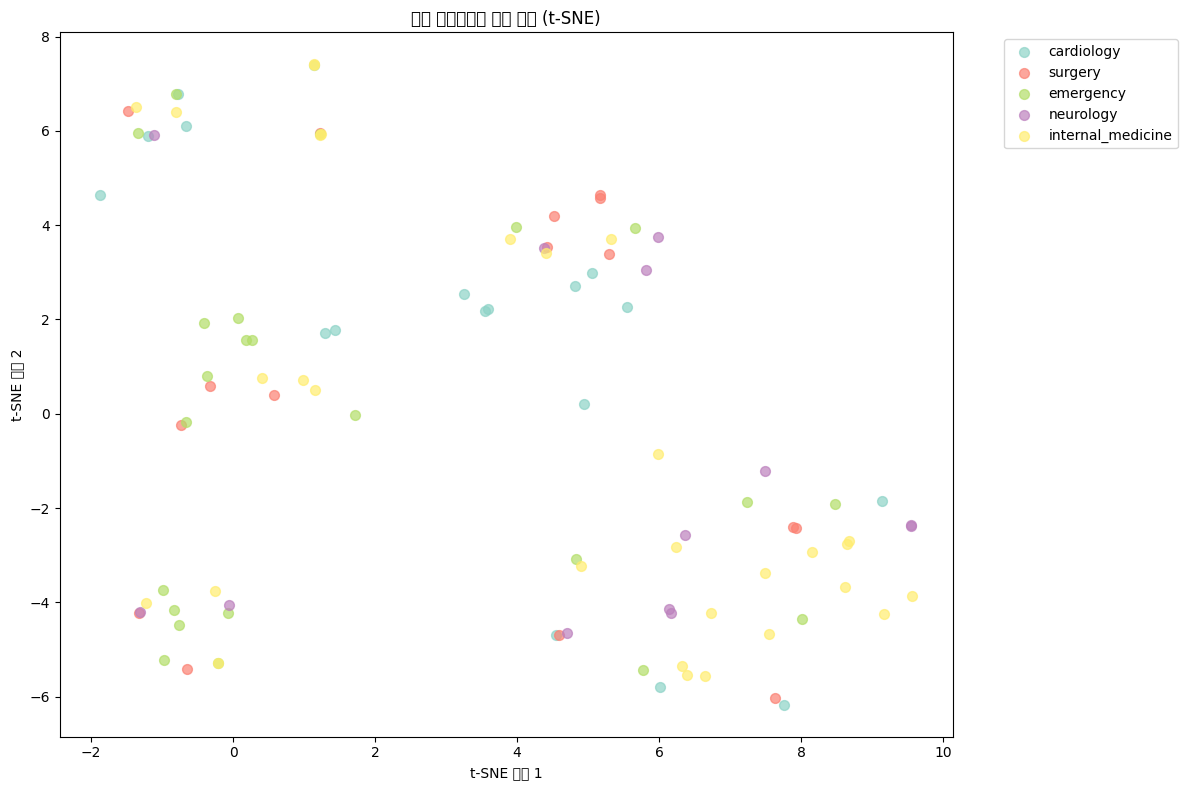

✅ 시각화 완료

📋 최종 검증 결과
Basic Info: ✅ PASS
Metadata: ✅ PASS
Search Quality: ✅ PASS
Similarity: ✅ PASS
Distribution: ✅ PASS

🎯 전체 점수: 100.0% (5/5)
🎉 벡터 스토어가 성공적으로 구축되었습니다!


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from collections import Counter
import seaborn as sns

class VectorStoreValidator:
    """
    벡터 스토어 검증 및 테스트 클래스
    """
    
    def __init__(self, vector_store, vectorstore):
        self.vector_store = vector_store
        self.vectorstore = vectorstore
        
    def basic_info_check(self):
        """
        벡터 스토어 기본 정보 확인
        """
        print("=" * 60)
        print("🔍 벡터 스토어 기본 정보 검증")
        print("=" * 60)
        
        try:
            # 벡터 개수 확인
            total_vectors = self.vectorstore.index.ntotal
            print(f"✅ 총 벡터 개수: {total_vectors:,}개")
            
            # 벡터 차원 확인
            vector_dim = self.vectorstore.index.d
            print(f"✅ 벡터 차원: {vector_dim}차원")
            
            # 메타데이터 확인
            if hasattr(self.vectorstore, 'docstore'):
                doc_count = len(self.vectorstore.docstore._dict)
                print(f"✅ 저장된 문서 수: {doc_count:,}개")
            
            # 인덱스 타입 확인
            index_type = type(self.vectorstore.index).__name__
            print(f"✅ 인덱스 타입: {index_type}")
            
            return True
            
        except Exception as e:
            print(f"❌ 기본 정보 확인 실패: {e}")
            return False
    
    def metadata_analysis(self):
        """
        메타데이터 분석
        """
        print("\n" + "=" * 60)
        print("📊 메타데이터 분석")
        print("=" * 60)
        
        try:
            if not hasattr(self.vectorstore, 'docstore'):
                print("❌ 메타데이터 접근 불가")
                return False
            
            # 메타데이터 수집
            all_metadata = []
            for doc_id, doc in self.vectorstore.docstore._dict.items():
                if hasattr(doc, 'metadata'):
                    all_metadata.append(doc.metadata)
            
            print(f"✅ 메타데이터가 있는 문서: {len(all_metadata)}개")
            
            # 진료과별 분포
            departments = [meta.get('department', 'Unknown') for meta in all_metadata]
            dept_counter = Counter(departments)
            print(f"\n📋 진료과별 문서 분포:")
            for dept, count in dept_counter.most_common():
                print(f"  - {dept}: {count}개")
            
            # 문서 타입별 분포
            doc_types = [meta.get('document_type', 'Unknown') for meta in all_metadata]
            type_counter = Counter(doc_types)
            print(f"\n📋 문서 타입별 분포:")
            for doc_type, count in type_counter.most_common():
                print(f"  - {doc_type}: {count}개")
            
            # 성별 분포
            genders = [meta.get('gender', 'Unknown') for meta in all_metadata]
            gender_counter = Counter(genders)
            print(f"\n📋 성별 분포:")
            for gender, count in gender_counter.items():
                print(f"  - {gender}: {count}개")
            
            return True
            
        except Exception as e:
            print(f"❌ 메타데이터 분석 실패: {e}")
            return False
    
    def search_quality_test(self):
        """
        검색 품질 테스트
        """
        print("\n" + "=" * 60)
        print("🔍 검색 품질 테스트")
        print("=" * 60)
        
        # 다양한 테스트 쿼리
        test_queries = [
            ("당뇨병", "diabetes"),
            ("고혈압", "hypertension"),  
            ("심장", "heart"),
            ("수술", "surgery"),
            ("약물", "medication"),
            ("검사", "test"),
            ("진단", "diagnosis"),
            ("여성 환자", "female patient"),
            ("응급실", "emergency"),
            ("내과", "internal medicine")
        ]
        
        successful_searches = 0
        total_results = 0
        
        for korean_query, english_desc in test_queries:
            try:
                print(f"\n🔍 테스트 쿼리: '{korean_query}' ({english_desc})")
                
                # 검색 실행
                results = self.vector_store.search_similar_documents(
                    korean_query, 
                    self.vectorstore, 
                    k=3
                )
                
                if results:
                    print(f"✅ 검색 성공: {len(results)}개 결과")
                    successful_searches += 1
                    total_results += len(results)
                    
                    # 첫 번째 결과 미리보기
                    first_result = results[0]
                    print(f"   👤 환자: {first_result.metadata.get('name', 'N/A')}")
                    print(f"   🏥 진료과: {first_result.metadata.get('department', 'N/A')}")
                    print(f"   📄 문서타입: {first_result.metadata.get('document_type', 'N/A')}")
                    print(f"   📝 내용: {first_result.page_content[:100]}...")
                else:
                    print(f"❌ 검색 실패: 결과 없음")
                    
            except Exception as e:
                print(f"❌ 검색 오류: {e}")
        
        success_rate = (successful_searches / len(test_queries)) * 100
        avg_results = total_results / successful_searches if successful_searches > 0 else 0
        
        print(f"\n📊 검색 성능 요약:")
        print(f"   성공률: {success_rate:.1f}% ({successful_searches}/{len(test_queries)})")
        print(f"   평균 결과 수: {avg_results:.1f}개")
        
        return success_rate >= 80  # 80% 이상 성공하면 PASS
    
    def similarity_test(self):
        """
        유사도 품질 테스트
        """
        print("\n" + "=" * 60)
        print("📏 유사도 품질 테스트")
        print("=" * 60)
        
        try:
            # 관련성이 높은 쿼리 쌍들로 테스트
            related_pairs = [
                # 1. 당뇨병 관련 쌍
                ("당뇨병", "혈당이 높은 환자"),
                ("당뇨병", "인슐린 치료"),
                ("제2형 당뇨병", "혈당 조절"),
                
                # 2. 고혈압 관련 쌍  
                ("고혈압", "혈압이 높은 환자"),
                ("고혈압", "혈압약"),
                ("고혈압", "수축기 혈압"),
                
                # 3. 심장질환 관련 쌍
                ("심장병", "심근경색"),
                ("심장병", "흉통"),
                ("부정맥", "심전도"),
                ("협심증", "가슴 통증"),
                
                # 4. 호흡기 관련 쌍
                ("폐렴", "기침"),
                ("천식", "호흡곤란"),
                ("폐렴", "발열"),
                
                # 5. 소화기 관련 쌍
                ("위염", "복통"),
                ("위궤양", "속 쓰림"),
                ("간염", "간 기능 검사"),
                
                # 6. 신경계 관련 쌍
                ("뇌졸중", "마비 증상"),
                ("두통", "편두통"),
                ("치매", "기억력 저하"),
                
                # 7. 검사 관련 쌍
                ("혈액검사", "CBC"),
                ("영상검사", "CT 촬영"),
                ("심전도", "EKG"),
                
                # 8. 치료 관련 쌍
                ("수술", "전신마취"),
                ("약물치료", "처방전"),
                ("물리치료", "재활"),
                
                # 9. 증상 관련 쌍
                ("발열", "체온 상승"),
                ("어지러움", "현기증"),
                ("구토", "메스꺼움"),
                
                # 10. 응급상황 관련 쌍
                ("응급실", "응급환자"),
                ("쇼크", "혈압 저하"),
                ("심정지", "심폐소생술")
            ]
            
            similarity_scores = []
            
            for query1, query2 in related_pairs:
                print(f"\n🔍 연관 쿼리 테스트: '{query1}' vs '{query2}'")
                
                # 각각 검색
                results1 = self.vector_store.search_similar_documents(query1, self.vectorstore, k=5)
                results2 = self.vector_store.search_similar_documents(query2, self.vectorstore, k=5)
                
                if results1 and results2:
                    # 결과 문서들의 환자 ID 비교
                    patients1 = set(doc.metadata.get('patient_id') for doc in results1)
                    patients2 = set(doc.metadata.get('patient_id') for doc in results2)
                    
                    # 교집합 비율 계산 (관련성 지표)
                    overlap = len(patients1.intersection(patients2))
                    total_unique = len(patients1.union(patients2))
                    similarity = overlap / total_unique if total_unique > 0 else 0
                    
                    similarity_scores.append(similarity)
                    print(f"   📊 환자 겹침률: {similarity:.2%} ({overlap}/{total_unique})")
                else:
                    print(f"   ❌ 검색 실패")
            
            if similarity_scores:
                avg_similarity = np.mean(similarity_scores)
                print(f"\n📊 평균 연관성 점수: {avg_similarity:.2%}")
                return avg_similarity >= 0.1  # 10% 이상 겹치면 PASS
            else:
                return False
                
        except Exception as e:
            print(f"❌ 유사도 테스트 실패: {e}")
            return False
    
    def vector_distribution_analysis(self, sample_size=100):
        """
        벡터 분포 분석 (시각화)
        """
        print("\n" + "=" * 60)
        print("📈 벡터 분포 분석")
        print("=" * 60)
        
        try:
            # 샘플 벡터 추출
            total_vectors = self.vectorstore.index.ntotal
            sample_indices = np.random.choice(
                total_vectors, 
                min(sample_size, total_vectors), 
                replace=False
            )
            
            # 벡터 데이터 추출
            sample_vectors = []
            sample_metadata = []
            
            for idx in sample_indices:
                vector = self.vectorstore.index.reconstruct(int(idx))
                sample_vectors.append(vector)
                
                # 메타데이터 가져오기
                if hasattr(self.vectorstore, 'docstore'):
                    doc_id = list(self.vectorstore.docstore._dict.keys())[idx]
                    doc = self.vectorstore.docstore._dict[doc_id]
                    if hasattr(doc, 'metadata'):
                        sample_metadata.append(doc.metadata)
                    else:
                        sample_metadata.append({})
                else:
                    sample_metadata.append({})
            
            sample_vectors = np.array(sample_vectors)
            print(f"✅ {len(sample_vectors)}개 벡터 샘플 추출")
            
            # 기본 통계
            print(f"📊 벡터 통계:")
            print(f"   평균 크기: {np.mean(np.linalg.norm(sample_vectors, axis=1)):.4f}")
            print(f"   표준편차: {np.std(np.linalg.norm(sample_vectors, axis=1)):.4f}")
            print(f"   최소값: {np.min(sample_vectors):.4f}")
            print(f"   최대값: {np.max(sample_vectors):.4f}")
            
            # t-SNE로 2D 시각화
            if len(sample_vectors) >= 10:
                print("\n🎨 t-SNE 시각화 생성 중...")
                tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(sample_vectors)-1))
                vectors_2d = tsne.fit_transform(sample_vectors)
                
                # 진료과별 색상 매핑
                departments = [meta.get('department', 'Unknown') for meta in sample_metadata]
                unique_depts = list(set(departments))
                colors = plt.cm.Set3(np.linspace(0, 1, len(unique_depts)))
                dept_color_map = dict(zip(unique_depts, colors))
                
                plt.figure(figsize=(12, 8))
                
                for dept in unique_depts:
                    dept_indices = [i for i, d in enumerate(departments) if d == dept]
                    if dept_indices:
                        plt.scatter(
                            vectors_2d[dept_indices, 0], 
                            vectors_2d[dept_indices, 1],
                            c=[dept_color_map[dept]], 
                            label=dept, 
                            alpha=0.7,
                            s=50
                        )
                
                plt.title('벡터 공간에서의 문서 분포 (t-SNE)')
                plt.xlabel('t-SNE 차원 1')
                plt.ylabel('t-SNE 차원 2')
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.tight_layout()
                plt.show()
                
                print("✅ 시각화 완료")
            
            return True
            
        except Exception as e:
            print(f"❌ 벡터 분포 분석 실패: {e}")
            import traceback
            print(traceback.format_exc())
            return False
    
    def comprehensive_validation(self):
        """
        종합 검증 실행
        """
        print("🚀 벡터 스토어 종합 검증 시작")
        print("=" * 80)
        
        results = {
            'basic_info': self.basic_info_check(),
            'metadata': self.metadata_analysis(),
            'search_quality': self.search_quality_test(),
            'similarity': self.similarity_test(),
            'distribution': self.vector_distribution_analysis()
        }
        
        print("\n" + "=" * 80)
        print("📋 최종 검증 결과")
        print("=" * 80)
        
        passed_tests = 0
        total_tests = len(results)
        
        for test_name, result in results.items():
            status = "✅ PASS" if result else "❌ FAIL"
            print(f"{test_name.replace('_', ' ').title()}: {status}")
            if result:
                passed_tests += 1
        
        overall_score = (passed_tests / total_tests) * 100
        print(f"\n🎯 전체 점수: {overall_score:.1f}% ({passed_tests}/{total_tests})")
        
        if overall_score >= 80:
            print("🎉 벡터 스토어가 성공적으로 구축되었습니다!")
        elif overall_score >= 60:
            print("⚠️  벡터 스토어가 구축되었지만 일부 개선이 필요합니다.")
        else:
            print("❌ 벡터 스토어에 심각한 문제가 있습니다. 재구축을 권장합니다.")
        
        return overall_score >= 60

# 사용 예시
if __name__ == "__main__":
    # 벡터 스토어 검증 실행
    validator = VectorStoreValidator(vector_store, vectorstore)
    validator.comprehensive_validation()

# 검증2 unified

2025-05-25 00:22:23,045 - INFO - Using device: cpu
2025-05-25 00:22:23,046 - INFO - multilingual-e5-large 모델 로드 중...
2025-05-25 00:22:23,048 - INFO - Load pretrained SentenceTransformer: intfloat/multilingual-e5-large
2025-05-25 00:22:26,955 - INFO - 임베딩 모델 로드 완료
2025-05-25 00:22:26,956 - INFO - vector_stores\medical_vector_store_e5_unified에서 벡터 스토어 로드 중...
2025-05-25 00:22:27,024 - WARNING - `embedding_function` is expected to be an Embeddings object, support for passing in a function will soon be removed.
2025-05-25 00:22:27,024 - INFO - 벡터 스토어 로드 완료
2025-05-25 00:22:27,028 - INFO - 쿼리로 검색 중: '당뇨병' (상위 3개 결과)


✅ 벡터 스토어 로드 완료!
🚀 벡터 스토어 종합 검증 시작
🔍 벡터 스토어 기본 정보 검증
✅ 총 벡터 개수: 5,196개
✅ 벡터 차원: 1024차원
✅ 저장된 문서 수: 5,196개
✅ 인덱스 타입: IndexFlatL2

📊 메타데이터 분석
✅ 메타데이터가 있는 문서: 5196개

📋 진료과별 문서 분포:
  - internal_medicine: 1501개
  - emergency: 1231개
  - surgery: 999개
  - cardiology: 832개
  - neurology: 633개

📋 문서 타입별 분포:
  - visit: 2796개
  - lab_result: 1188개
  - integrated_record: 275개
  - imaging_study: 273개
  - diagnosis: 223개
  - procedure: 178개
  - basic_info: 165개
  - medication: 98개

📋 성별 분포:
  - 남: 2317개
  - 여: 2879개

🔍 검색 품질 테스트

🔍 테스트 쿼리: '당뇨병' (diabetes)


2025-05-25 00:22:28,173 - INFO - 기본 검색 완료: 3개 문서 발견
2025-05-25 00:22:28,174 - INFO - 쿼리로 검색 중: '고혈압' (상위 3개 결과)


✅ 검색 성공: 3개 결과
   👤 환자: 김바돌
   🏥 진료과: internal_medicine
   📄 문서타입: diagnosis
   📝 내용: 환자 ID: I16626
                이름: 김바돌
                성별: 남
                나이: 49

                ...

🔍 테스트 쿼리: '고혈압' (hypertension)


2025-05-25 00:22:28,387 - INFO - 기본 검색 완료: 3개 문서 발견
2025-05-25 00:22:28,388 - INFO - 쿼리로 검색 중: '심장' (상위 3개 결과)
2025-05-25 00:22:28,564 - INFO - 기본 검색 완료: 3개 문서 발견
2025-05-25 00:22:28,565 - INFO - 쿼리로 검색 중: '수술' (상위 3개 결과)


✅ 검색 성공: 3개 결과
   👤 환자: 이자미
   🏥 진료과: internal_medicine
   📄 문서타입: diagnosis
   📝 내용: 환자 ID: I65633
                이름: 이자미
                성별: 여
                나이: 68

                ...

🔍 테스트 쿼리: '심장' (heart)
✅ 검색 성공: 3개 결과
   👤 환자: 이파미
   🏥 진료과: cardiology
   📄 문서타입: diagnosis
   📝 내용: 환자 ID: C24696
                이름: 이파미
                성별: 여
                나이: 67

                ...

🔍 테스트 쿼리: '수술' (surgery)


2025-05-25 00:22:28,740 - INFO - 기본 검색 완료: 3개 문서 발견
2025-05-25 00:22:28,741 - INFO - 쿼리로 검색 중: '약물' (상위 3개 결과)
2025-05-25 00:22:28,930 - INFO - 기본 검색 완료: 3개 문서 발견


✅ 검색 성공: 3개 결과
   👤 환자: 김바돌
   🏥 진료과: internal_medicine
   📄 문서타입: procedure
   📝 내용: 환자 ID: I16626
                이름: 김바돌
                성별: 남
                나이: 49

                ...

🔍 테스트 쿼리: '약물' (medication)


2025-05-25 00:22:28,932 - INFO - 쿼리로 검색 중: '검사' (상위 3개 결과)
2025-05-25 00:22:29,120 - INFO - 기본 검색 완료: 3개 문서 발견


✅ 검색 성공: 3개 결과
   👤 환자: 김파돌
   🏥 진료과: emergency
   📄 문서타입: diagnosis
   📝 내용: 환자 ID: E36456
                이름: 김파돌
                성별: 남
                나이: 11

                ...

🔍 테스트 쿼리: '검사' (test)


2025-05-25 00:22:29,121 - INFO - 쿼리로 검색 중: '진단' (상위 3개 결과)
2025-05-25 00:22:29,292 - INFO - 기본 검색 완료: 3개 문서 발견
2025-05-25 00:22:29,293 - INFO - 쿼리로 검색 중: '여성 환자' (상위 3개 결과)


✅ 검색 성공: 3개 결과
   👤 환자: 김마돌
   🏥 진료과: cardiology
   📄 문서타입: lab_result
   📝 내용: 해석: 모든 검사 결과가 정상 범위 내에 있습니다....

🔍 테스트 쿼리: '진단' (diagnosis)
✅ 검색 성공: 3개 결과
   👤 환자: 김바돌
   🏥 진료과: surgery
   📄 문서타입: diagnosis
   📝 내용: 환자 ID: S20491
                이름: 김바돌
                성별: 남
                나이: 65

                ...

🔍 테스트 쿼리: '여성 환자' (female patient)


2025-05-25 00:22:29,478 - INFO - 기본 검색 완료: 3개 문서 발견
2025-05-25 00:22:29,479 - INFO - 쿼리로 검색 중: '응급실' (상위 3개 결과)
2025-05-25 00:22:29,677 - INFO - 기본 검색 완료: 3개 문서 발견


✅ 검색 성공: 3개 결과
   👤 환자: 이바미
   🏥 진료과: emergency
   📄 문서타입: visit
   📝 내용: 환자 ID: E57017
                이름: 이바미
                성별: 여
                나이: 36

                ...

🔍 테스트 쿼리: '응급실' (emergency)


2025-05-25 00:22:29,678 - INFO - 쿼리로 검색 중: '내과' (상위 3개 결과)
2025-05-25 00:22:29,855 - INFO - 기본 검색 완료: 3개 문서 발견
2025-05-25 00:22:29,856 - INFO - 쿼리로 검색 중: '당뇨병' (상위 5개 결과)


✅ 검색 성공: 3개 결과
   👤 환자: 김가돌
   🏥 진료과: emergency
   📄 문서타입: visit
   📝 내용: 환자 ID: E11422
                이름: 김가돌
                성별: 남
                나이: 27

                ...

🔍 테스트 쿼리: '내과' (internal medicine)
✅ 검색 성공: 3개 결과
   👤 환자: 이나미
   🏥 진료과: internal_medicine
   📄 문서타입: procedure
   📝 내용: 환자 ID: I12953
                이름: 이나미
                성별: 여
                나이: 43

                ...

📊 검색 성능 요약:
   성공률: 100.0% (10/10)
   평균 결과 수: 3.0개

📏 유사도 품질 테스트

🔍 연관 쿼리 테스트: '당뇨병' vs '혈당이 높은 환자'


2025-05-25 00:22:30,029 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:30,030 - INFO - 쿼리로 검색 중: '혈당이 높은 환자' (상위 5개 결과)
2025-05-25 00:22:30,210 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:30,211 - INFO - 쿼리로 검색 중: '당뇨병' (상위 5개 결과)
2025-05-25 00:22:30,393 - INFO - 기본 검색 완료: 5개 문서 발견


   📊 환자 겹침률: 0.00% (0/9)

🔍 연관 쿼리 테스트: '당뇨병' vs '인슐린 치료'


2025-05-25 00:22:30,394 - INFO - 쿼리로 검색 중: '인슐린 치료' (상위 5개 결과)
2025-05-25 00:22:30,586 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:30,587 - INFO - 쿼리로 검색 중: '제2형 당뇨병' (상위 5개 결과)
2025-05-25 00:22:30,767 - INFO - 기본 검색 완료: 5개 문서 발견


   📊 환자 겹침률: 50.00% (3/6)

🔍 연관 쿼리 테스트: '제2형 당뇨병' vs '혈당 조절'


2025-05-25 00:22:30,768 - INFO - 쿼리로 검색 중: '혈당 조절' (상위 5개 결과)
2025-05-25 00:22:30,946 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:30,947 - INFO - 쿼리로 검색 중: '고혈압' (상위 5개 결과)
2025-05-25 00:22:31,143 - INFO - 기본 검색 완료: 5개 문서 발견


   📊 환자 겹침률: 0.00% (0/9)

🔍 연관 쿼리 테스트: '고혈압' vs '혈압이 높은 환자'


2025-05-25 00:22:31,144 - INFO - 쿼리로 검색 중: '혈압이 높은 환자' (상위 5개 결과)
2025-05-25 00:22:31,352 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:31,353 - INFO - 쿼리로 검색 중: '고혈압' (상위 5개 결과)


   📊 환자 겹침률: 80.00% (4/5)

🔍 연관 쿼리 테스트: '고혈압' vs '혈압약'


2025-05-25 00:22:31,607 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:31,609 - INFO - 쿼리로 검색 중: '혈압약' (상위 5개 결과)
2025-05-25 00:22:31,791 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:31,792 - INFO - 쿼리로 검색 중: '고혈압' (상위 5개 결과)
2025-05-25 00:22:31,983 - INFO - 기본 검색 완료: 5개 문서 발견


   📊 환자 겹침률: 28.57% (2/7)

🔍 연관 쿼리 테스트: '고혈압' vs '수축기 혈압'


2025-05-25 00:22:31,984 - INFO - 쿼리로 검색 중: '수축기 혈압' (상위 5개 결과)
2025-05-25 00:22:32,174 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:32,175 - INFO - 쿼리로 검색 중: '심장병' (상위 5개 결과)
2025-05-25 00:22:32,365 - INFO - 기본 검색 완료: 5개 문서 발견


   📊 환자 겹침률: 14.29% (1/7)

🔍 연관 쿼리 테스트: '심장병' vs '심근경색'


2025-05-25 00:22:32,366 - INFO - 쿼리로 검색 중: '심근경색' (상위 5개 결과)
2025-05-25 00:22:32,546 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:32,547 - INFO - 쿼리로 검색 중: '심장병' (상위 5개 결과)
2025-05-25 00:22:32,730 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:32,731 - INFO - 쿼리로 검색 중: '흉통' (상위 5개 결과)


   📊 환자 겹침률: 50.00% (3/6)

🔍 연관 쿼리 테스트: '심장병' vs '흉통'


2025-05-25 00:22:32,925 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:32,926 - INFO - 쿼리로 검색 중: '부정맥' (상위 5개 결과)
2025-05-25 00:22:33,090 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:33,091 - INFO - 쿼리로 검색 중: '심전도' (상위 5개 결과)


   📊 환자 겹침률: 0.00% (0/9)

🔍 연관 쿼리 테스트: '부정맥' vs '심전도'


2025-05-25 00:22:33,267 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:33,268 - INFO - 쿼리로 검색 중: '협심증' (상위 5개 결과)
2025-05-25 00:22:33,429 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:33,430 - INFO - 쿼리로 검색 중: '가슴 통증' (상위 5개 결과)


   📊 환자 겹침률: 0.00% (0/9)

🔍 연관 쿼리 테스트: '협심증' vs '가슴 통증'


2025-05-25 00:22:33,615 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:33,616 - INFO - 쿼리로 검색 중: '폐렴' (상위 5개 결과)
2025-05-25 00:22:33,787 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:33,787 - INFO - 쿼리로 검색 중: '기침' (상위 5개 결과)


   📊 환자 겹침률: 0.00% (0/10)

🔍 연관 쿼리 테스트: '폐렴' vs '기침'


2025-05-25 00:22:33,960 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:33,961 - INFO - 쿼리로 검색 중: '천식' (상위 5개 결과)
2025-05-25 00:22:34,125 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:34,126 - INFO - 쿼리로 검색 중: '호흡곤란' (상위 5개 결과)


   📊 환자 겹침률: 11.11% (1/9)

🔍 연관 쿼리 테스트: '천식' vs '호흡곤란'


2025-05-25 00:22:34,294 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:34,295 - INFO - 쿼리로 검색 중: '폐렴' (상위 5개 결과)
2025-05-25 00:22:34,460 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:34,461 - INFO - 쿼리로 검색 중: '발열' (상위 5개 결과)


   📊 환자 겹침률: 0.00% (0/10)

🔍 연관 쿼리 테스트: '폐렴' vs '발열'


2025-05-25 00:22:34,624 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:34,625 - INFO - 쿼리로 검색 중: '위염' (상위 5개 결과)
2025-05-25 00:22:34,794 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:34,794 - INFO - 쿼리로 검색 중: '복통' (상위 5개 결과)


   📊 환자 겹침률: 0.00% (0/10)

🔍 연관 쿼리 테스트: '위염' vs '복통'


2025-05-25 00:22:34,970 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:34,971 - INFO - 쿼리로 검색 중: '위궤양' (상위 5개 결과)
2025-05-25 00:22:35,161 - INFO - 기본 검색 완료: 5개 문서 발견


   📊 환자 겹침률: 11.11% (1/9)

🔍 연관 쿼리 테스트: '위궤양' vs '속 쓰림'


2025-05-25 00:22:35,162 - INFO - 쿼리로 검색 중: '속 쓰림' (상위 5개 결과)
2025-05-25 00:22:35,361 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:35,361 - INFO - 쿼리로 검색 중: '간염' (상위 5개 결과)
2025-05-25 00:22:35,539 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:35,539 - INFO - 쿼리로 검색 중: '간 기능 검사' (상위 5개 결과)


   📊 환자 겹침률: 0.00% (0/10)

🔍 연관 쿼리 테스트: '간염' vs '간 기능 검사'


2025-05-25 00:22:35,736 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:35,737 - INFO - 쿼리로 검색 중: '뇌졸중' (상위 5개 결과)
2025-05-25 00:22:35,930 - INFO - 기본 검색 완료: 5개 문서 발견


   📊 환자 겹침률: 0.00% (0/9)

🔍 연관 쿼리 테스트: '뇌졸중' vs '마비 증상'


2025-05-25 00:22:35,931 - INFO - 쿼리로 검색 중: '마비 증상' (상위 5개 결과)
2025-05-25 00:22:36,122 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:36,123 - INFO - 쿼리로 검색 중: '두통' (상위 5개 결과)
2025-05-25 00:22:36,298 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:36,299 - INFO - 쿼리로 검색 중: '편두통' (상위 5개 결과)


   📊 환자 겹침률: 25.00% (2/8)

🔍 연관 쿼리 테스트: '두통' vs '편두통'


2025-05-25 00:22:36,488 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:36,489 - INFO - 쿼리로 검색 중: '치매' (상위 5개 결과)
2025-05-25 00:22:36,659 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:36,659 - INFO - 쿼리로 검색 중: '기억력 저하' (상위 5개 결과)


   📊 환자 겹침률: 14.29% (1/7)

🔍 연관 쿼리 테스트: '치매' vs '기억력 저하'


2025-05-25 00:22:36,837 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:36,838 - INFO - 쿼리로 검색 중: '혈액검사' (상위 5개 결과)


   📊 환자 겹침률: 28.57% (2/7)

🔍 연관 쿼리 테스트: '혈액검사' vs 'CBC'


2025-05-25 00:22:37,064 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:37,065 - INFO - 쿼리로 검색 중: 'CBC' (상위 5개 결과)
2025-05-25 00:22:37,267 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:37,268 - INFO - 쿼리로 검색 중: '영상검사' (상위 5개 결과)
2025-05-25 00:22:37,448 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:37,449 - INFO - 쿼리로 검색 중: 'CT 촬영' (상위 5개 결과)


   📊 환자 겹침률: 0.00% (0/8)

🔍 연관 쿼리 테스트: '영상검사' vs 'CT 촬영'


2025-05-25 00:22:37,627 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:37,627 - INFO - 쿼리로 검색 중: '심전도' (상위 5개 결과)
2025-05-25 00:22:37,811 - INFO - 기본 검색 완료: 5개 문서 발견


   📊 환자 겹침률: 0.00% (0/10)

🔍 연관 쿼리 테스트: '심전도' vs 'EKG'


2025-05-25 00:22:37,812 - INFO - 쿼리로 검색 중: 'EKG' (상위 5개 결과)
2025-05-25 00:22:37,982 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:37,982 - INFO - 쿼리로 검색 중: '수술' (상위 5개 결과)
2025-05-25 00:22:38,144 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:38,145 - INFO - 쿼리로 검색 중: '전신마취' (상위 5개 결과)


   📊 환자 겹침률: 0.00% (0/9)

🔍 연관 쿼리 테스트: '수술' vs '전신마취'


2025-05-25 00:22:38,312 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:38,313 - INFO - 쿼리로 검색 중: '약물치료' (상위 5개 결과)
2025-05-25 00:22:38,494 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:38,495 - INFO - 쿼리로 검색 중: '처방전' (상위 5개 결과)


   📊 환자 겹침률: 0.00% (0/10)

🔍 연관 쿼리 테스트: '약물치료' vs '처방전'


2025-05-25 00:22:38,676 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:38,677 - INFO - 쿼리로 검색 중: '물리치료' (상위 5개 결과)
2025-05-25 00:22:38,838 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:38,839 - INFO - 쿼리로 검색 중: '재활' (상위 5개 결과)


   📊 환자 겹침률: 11.11% (1/9)

🔍 연관 쿼리 테스트: '물리치료' vs '재활'


2025-05-25 00:22:39,010 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:39,010 - INFO - 쿼리로 검색 중: '발열' (상위 5개 결과)
2025-05-25 00:22:39,193 - INFO - 기본 검색 완료: 5개 문서 발견


   📊 환자 겹침률: 11.11% (1/9)

🔍 연관 쿼리 테스트: '발열' vs '체온 상승'


2025-05-25 00:22:39,194 - INFO - 쿼리로 검색 중: '체온 상승' (상위 5개 결과)
2025-05-25 00:22:39,372 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:39,373 - INFO - 쿼리로 검색 중: '어지러움' (상위 5개 결과)
2025-05-25 00:22:39,546 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:39,547 - INFO - 쿼리로 검색 중: '현기증' (상위 5개 결과)


   📊 환자 겹침률: 11.11% (1/9)

🔍 연관 쿼리 테스트: '어지러움' vs '현기증'


2025-05-25 00:22:39,735 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:39,736 - INFO - 쿼리로 검색 중: '구토' (상위 5개 결과)
2025-05-25 00:22:39,903 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:39,904 - INFO - 쿼리로 검색 중: '메스꺼움' (상위 5개 결과)


   📊 환자 겹침률: 42.86% (3/7)

🔍 연관 쿼리 테스트: '구토' vs '메스꺼움'


2025-05-25 00:22:40,081 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:40,082 - INFO - 쿼리로 검색 중: '응급실' (상위 5개 결과)
2025-05-25 00:22:40,252 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:40,252 - INFO - 쿼리로 검색 중: '응급환자' (상위 5개 결과)


   📊 환자 겹침률: 0.00% (0/10)

🔍 연관 쿼리 테스트: '응급실' vs '응급환자'


2025-05-25 00:22:40,432 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:40,433 - INFO - 쿼리로 검색 중: '쇼크' (상위 5개 결과)
2025-05-25 00:22:40,609 - INFO - 기본 검색 완료: 5개 문서 발견


   📊 환자 겹침률: 33.33% (2/6)

🔍 연관 쿼리 테스트: '쇼크' vs '혈압 저하'


2025-05-25 00:22:40,610 - INFO - 쿼리로 검색 중: '혈압 저하' (상위 5개 결과)
2025-05-25 00:22:40,777 - INFO - 기본 검색 완료: 5개 문서 발견
2025-05-25 00:22:40,777 - INFO - 쿼리로 검색 중: '심정지' (상위 5개 결과)
2025-05-25 00:22:40,964 - INFO - 기본 검색 완료: 5개 문서 발견


   📊 환자 겹침률: 0.00% (0/7)

🔍 연관 쿼리 테스트: '심정지' vs '심폐소생술'


2025-05-25 00:22:40,965 - INFO - 쿼리로 검색 중: '심폐소생술' (상위 5개 결과)
2025-05-25 00:22:41,158 - INFO - 기본 검색 완료: 5개 문서 발견


   📊 환자 겹침률: 0.00% (0/9)

📊 평균 연관성 점수: 13.63%

📈 벡터 분포 분석
✅ 100개 벡터 샘플 추출
📊 벡터 통계:
   평균 크기: 1.0000
   표준편차: 0.0000
   최소값: -0.1263
   최대값: 0.2556

🎨 t-SNE 시각화 생성 중...


C:\Users\tjddl\AppData\Local\Temp\ipykernel_27352\876461994.py:333: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tjddl\AppData\Local\Temp\ipykernel_27352\876461994.py:333: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tjddl\AppData\Local\Temp\ipykernel_27352\876461994.py:333: UserWarning: Glyph 48289 (\N{HANGUL SYLLABLE BEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tjddl\AppData\Local\Temp\ipykernel_27352\876461994.py:333: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tjddl\AppData\Local\Temp\ipykernel_27352\876461994.py:333: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tjddl\AppData\Local\Temp\ipykernel_27352\876461994.py:333: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing fr

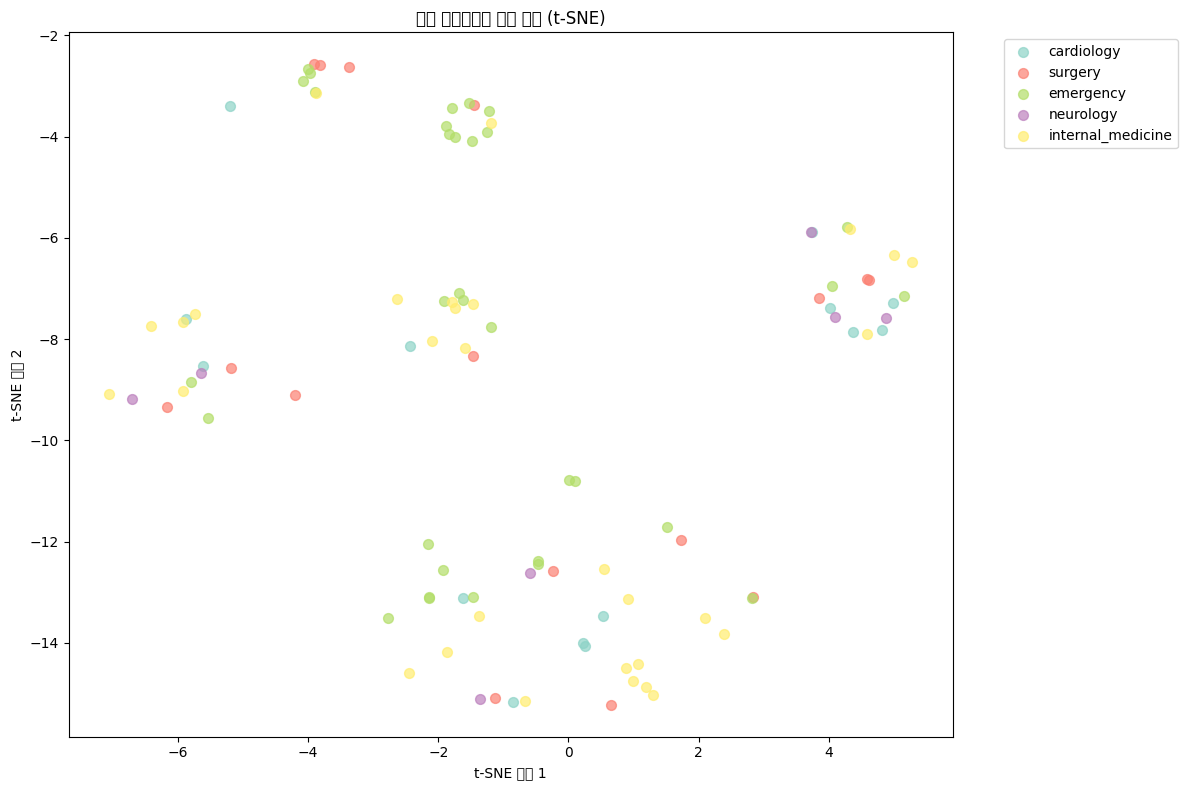

✅ 시각화 완료

📋 최종 검증 결과
Basic Info: ✅ PASS
Metadata: ✅ PASS
Search Quality: ✅ PASS
Similarity: ✅ PASS
Distribution: ✅ PASS

🎯 전체 점수: 100.0% (5/5)
🎉 벡터 스토어가 성공적으로 구축되었습니다!


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from collections import Counter
import seaborn as sns

class VectorStoreValidator:
    """
    벡터 스토어 검증 및 테스트 클래스
    """
    
    def __init__(self, vector_store, medical_vector_store_e5_unified):
        self.vector_store = vector_store  # MedicalVectorStoreE5 인스턴스
        self.medical_vector_store_e5_unified = medical_vector_store_e5_unified  # FAISS 벡터스토어 객체
        
    def basic_info_check(self):
        """
        벡터 스토어 기본 정보 확인
        """
        print("=" * 60)
        print("🔍 벡터 스토어 기본 정보 검증")
        print("=" * 60)
        
        try:
            # 벡터 개수 확인
            total_vectors = self.medical_vector_store_e5_unified.index.ntotal
            print(f"✅ 총 벡터 개수: {total_vectors:,}개")
            
            # 벡터 차원 확인
            vector_dim = self.medical_vector_store_e5_unified.index.d
            print(f"✅ 벡터 차원: {vector_dim}차원")
            
            # 메타데이터 확인
            if hasattr(self.medical_vector_store_e5_unified, 'docstore'):
                doc_count = len(self.medical_vector_store_e5_unified.docstore._dict)
                print(f"✅ 저장된 문서 수: {doc_count:,}개")
            
            # 인덱스 타입 확인
            index_type = type(self.medical_vector_store_e5_unified.index).__name__
            print(f"✅ 인덱스 타입: {index_type}")
            
            return True
            
        except Exception as e:
            print(f"❌ 기본 정보 확인 실패: {e}")
            return False
    
    def metadata_analysis(self):
        """
        메타데이터 분석
        """
        print("\n" + "=" * 60)
        print("📊 메타데이터 분석")
        print("=" * 60)
        
        try:
            if not hasattr(self.medical_vector_store_e5_unified, 'docstore'):
                print("❌ 메타데이터 접근 불가")
                return False
            
            # 메타데이터 수집
            all_metadata = []
            for doc_id, doc in self.medical_vector_store_e5_unified.docstore._dict.items():
                if hasattr(doc, 'metadata'):
                    all_metadata.append(doc.metadata)
            
            print(f"✅ 메타데이터가 있는 문서: {len(all_metadata)}개")
            
            # 진료과별 분포
            departments = [meta.get('department', 'Unknown') for meta in all_metadata]
            dept_counter = Counter(departments)
            print(f"\n📋 진료과별 문서 분포:")
            for dept, count in dept_counter.most_common():
                print(f"  - {dept}: {count}개")
            
            # 문서 타입별 분포
            doc_types = [meta.get('document_type', 'Unknown') for meta in all_metadata]
            type_counter = Counter(doc_types)
            print(f"\n📋 문서 타입별 분포:")
            for doc_type, count in type_counter.most_common():
                print(f"  - {doc_type}: {count}개")
            
            # 성별 분포
            genders = [meta.get('gender', 'Unknown') for meta in all_metadata]
            gender_counter = Counter(genders)
            print(f"\n📋 성별 분포:")
            for gender, count in gender_counter.items():
                print(f"  - {gender}: {count}개")
            
            return True
            
        except Exception as e:
            print(f"❌ 메타데이터 분석 실패: {e}")
            return False
    
    def search_quality_test(self):
        """
        검색 품질 테스트
        """
        print("\n" + "=" * 60)
        print("🔍 검색 품질 테스트")
        print("=" * 60)
        
        # 다양한 테스트 쿼리
        test_queries = [
            ("당뇨병", "diabetes"),
            ("고혈압", "hypertension"),  
            ("심장", "heart"),
            ("수술", "surgery"),
            ("약물", "medication"),
            ("검사", "test"),
            ("진단", "diagnosis"),
            ("여성 환자", "female patient"),
            ("응급실", "emergency"),
            ("내과", "internal medicine")
        ]
        
        successful_searches = 0
        total_results = 0
        
        for korean_query, english_desc in test_queries:
            try:
                print(f"\n🔍 테스트 쿼리: '{korean_query}' ({english_desc})")
                
                # 검색 실행 - vector_store의 search_similar_documents 메서드 사용
                results = self.vector_store.search_similar_documents(
                    korean_query, 
                    self.medical_vector_store_e5_unified, 
                    k=3
                )
                
                if results:
                    print(f"✅ 검색 성공: {len(results)}개 결과")
                    successful_searches += 1
                    total_results += len(results)
                    
                    # 첫 번째 결과 미리보기
                    first_result = results[0]
                    print(f"   👤 환자: {first_result.metadata.get('name', 'N/A')}")
                    print(f"   🏥 진료과: {first_result.metadata.get('department', 'N/A')}")
                    print(f"   📄 문서타입: {first_result.metadata.get('document_type', 'N/A')}")
                    print(f"   📝 내용: {first_result.page_content[:100]}...")
                else:
                    print(f"❌ 검색 실패: 결과 없음")
                    
            except Exception as e:
                print(f"❌ 검색 오류: {e}")
        
        success_rate = (successful_searches / len(test_queries)) * 100
        avg_results = total_results / successful_searches if successful_searches > 0 else 0
        
        print(f"\n📊 검색 성능 요약:")
        print(f"   성공률: {success_rate:.1f}% ({successful_searches}/{len(test_queries)})")
        print(f"   평균 결과 수: {avg_results:.1f}개")
        
        return success_rate >= 80  # 80% 이상 성공하면 PASS
    
    def similarity_test(self):
        """
        유사도 품질 테스트
        """
        print("\n" + "=" * 60)
        print("📏 유사도 품질 테스트")
        print("=" * 60)
        
        try:
            # 관련성이 높은 쿼리 쌍들로 테스트
            related_pairs = [
                # 1. 당뇨병 관련 쌍
                ("당뇨병", "혈당이 높은 환자"),
                ("당뇨병", "인슐린 치료"),
                ("제2형 당뇨병", "혈당 조절"),
                
                # 2. 고혈압 관련 쌍  
                ("고혈압", "혈압이 높은 환자"),
                ("고혈압", "혈압약"),
                ("고혈압", "수축기 혈압"),
                
                # 3. 심장질환 관련 쌍
                ("심장병", "심근경색"),
                ("심장병", "흉통"),
                ("부정맥", "심전도"),
                ("협심증", "가슴 통증"),
                
                # 4. 호흡기 관련 쌍
                ("폐렴", "기침"),
                ("천식", "호흡곤란"),
                ("폐렴", "발열"),
                
                # 5. 소화기 관련 쌍
                ("위염", "복통"),
                ("위궤양", "속 쓰림"),
                ("간염", "간 기능 검사"),
                
                # 6. 신경계 관련 쌍
                ("뇌졸중", "마비 증상"),
                ("두통", "편두통"),
                ("치매", "기억력 저하"),
                
                # 7. 검사 관련 쌍
                ("혈액검사", "CBC"),
                ("영상검사", "CT 촬영"),
                ("심전도", "EKG"),
                
                # 8. 치료 관련 쌍
                ("수술", "전신마취"),
                ("약물치료", "처방전"),
                ("물리치료", "재활"),
                
                # 9. 증상 관련 쌍
                ("발열", "체온 상승"),
                ("어지러움", "현기증"),
                ("구토", "메스꺼움"),
                
                # 10. 응급상황 관련 쌍
                ("응급실", "응급환자"),
                ("쇼크", "혈압 저하"),
                ("심정지", "심폐소생술")
            ]
            
            similarity_scores = []
            
            for query1, query2 in related_pairs:
                print(f"\n🔍 연관 쿼리 테스트: '{query1}' vs '{query2}'")
                
                # 각각 검색
                results1 = self.vector_store.search_similar_documents(query1, self.medical_vector_store_e5_unified, k=5)
                results2 = self.vector_store.search_similar_documents(query2, self.medical_vector_store_e5_unified, k=5)
                
                if results1 and results2:
                    # 결과 문서들의 환자 ID 비교
                    patients1 = set(doc.metadata.get('patient_id') for doc in results1)
                    patients2 = set(doc.metadata.get('patient_id') for doc in results2)
                    
                    # 교집합 비율 계산 (관련성 지표)
                    overlap = len(patients1.intersection(patients2))
                    total_unique = len(patients1.union(patients2))
                    similarity = overlap / total_unique if total_unique > 0 else 0
                    
                    similarity_scores.append(similarity)
                    print(f"   📊 환자 겹침률: {similarity:.2%} ({overlap}/{total_unique})")
                else:
                    print(f"   ❌ 검색 실패")
            
            if similarity_scores:
                avg_similarity = np.mean(similarity_scores)
                print(f"\n📊 평균 연관성 점수: {avg_similarity:.2%}")
                return avg_similarity >= 0.1  # 10% 이상 겹치면 PASS
            else:
                return False
                
        except Exception as e:
            print(f"❌ 유사도 테스트 실패: {e}")
            return False
    
    def vector_distribution_analysis(self, sample_size=100):
        """
        벡터 분포 분석 (시각화)
        """
        print("\n" + "=" * 60)
        print("📈 벡터 분포 분석")
        print("=" * 60)
        
        try:
            # 샘플 벡터 추출
            total_vectors = self.medical_vector_store_e5_unified.index.ntotal
            sample_indices = np.random.choice(
                total_vectors, 
                min(sample_size, total_vectors), 
                replace=False
            )
            
            # 벡터 데이터 추출
            sample_vectors = []
            sample_metadata = []
            
            for idx in sample_indices:
                vector = self.medical_vector_store_e5_unified.index.reconstruct(int(idx))
                sample_vectors.append(vector)
                
                # 메타데이터 가져오기
                if hasattr(self.medical_vector_store_e5_unified, 'docstore'):
                    doc_id = list(self.medical_vector_store_e5_unified.docstore._dict.keys())[idx]
                    doc = self.medical_vector_store_e5_unified.docstore._dict[doc_id]
                    if hasattr(doc, 'metadata'):
                        sample_metadata.append(doc.metadata)
                    else:
                        sample_metadata.append({})
                else:
                    sample_metadata.append({})
            
            sample_vectors = np.array(sample_vectors)
            print(f"✅ {len(sample_vectors)}개 벡터 샘플 추출")
            
            # 기본 통계
            print(f"📊 벡터 통계:")
            print(f"   평균 크기: {np.mean(np.linalg.norm(sample_vectors, axis=1)):.4f}")
            print(f"   표준편차: {np.std(np.linalg.norm(sample_vectors, axis=1)):.4f}")
            print(f"   최소값: {np.min(sample_vectors):.4f}")
            print(f"   최대값: {np.max(sample_vectors):.4f}")
            
            # t-SNE로 2D 시각화
            if len(sample_vectors) >= 10:
                print("\n🎨 t-SNE 시각화 생성 중...")
                tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(sample_vectors)-1))
                vectors_2d = tsne.fit_transform(sample_vectors)
                
                # 진료과별 색상 매핑
                departments = [meta.get('department', 'Unknown') for meta in sample_metadata]
                unique_depts = list(set(departments))
                colors = plt.cm.Set3(np.linspace(0, 1, len(unique_depts)))
                dept_color_map = dict(zip(unique_depts, colors))
                
                plt.figure(figsize=(12, 8))
                
                for dept in unique_depts:
                    dept_indices = [i for i, d in enumerate(departments) if d == dept]
                    if dept_indices:
                        plt.scatter(
                            vectors_2d[dept_indices, 0], 
                            vectors_2d[dept_indices, 1],
                            c=[dept_color_map[dept]], 
                            label=dept, 
                            alpha=0.7,
                            s=50
                        )
                
                plt.title('벡터 공간에서의 문서 분포 (t-SNE)')
                plt.xlabel('t-SNE 차원 1')
                plt.ylabel('t-SNE 차원 2')
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.tight_layout()
                plt.show()
                
                print("✅ 시각화 완료")
            
            return True
            
        except Exception as e:
            print(f"❌ 벡터 분포 분석 실패: {e}")
            import traceback
            print(traceback.format_exc())
            return False
    
    def comprehensive_validation(self):
        """
        종합 검증 실행
        """
        print("🚀 벡터 스토어 종합 검증 시작")
        print("=" * 80)
        
        results = {
            'basic_info': self.basic_info_check(),
            'metadata': self.metadata_analysis(),
            'search_quality': self.search_quality_test(),
            'similarity': self.similarity_test(),
            'distribution': self.vector_distribution_analysis()
        }
        
        print("\n" + "=" * 80)
        print("📋 최종 검증 결과")
        print("=" * 80)
        
        passed_tests = 0
        total_tests = len(results)
        
        for test_name, result in results.items():
            status = "✅ PASS" if result else "❌ FAIL"
            print(f"{test_name.replace('_', ' ').title()}: {status}")
            if result:
                passed_tests += 1
        
        overall_score = (passed_tests / total_tests) * 100
        print(f"\n🎯 전체 점수: {overall_score:.1f}% ({passed_tests}/{total_tests})")
        
        if overall_score >= 80:
            print("🎉 벡터 스토어가 성공적으로 구축되었습니다!")
        elif overall_score >= 60:
            print("⚠️  벡터 스토어가 구축되었지만 일부 개선이 필요합니다.")
        else:
            print("❌ 벡터 스토어에 심각한 문제가 있습니다. 재구축을 권장합니다.")
        
        return overall_score >= 60

# 사용 예시
if __name__ == "__main__":
    # 먼저 벡터 스토어 로드
    vector_store = MedicalVectorStoreE5(
        data_path="./medical_data",
        vector_store_path="./vector_stores",
        use_gpu=True
    )
    
    # 저장된 벡터 스토어 로드
    medical_vector_store_e5_unified = vector_store.load_vector_store(
        store_name="medical_vector_store_e5_unified"
    )
    
    if medical_vector_store_e5_unified is not None:
        print("✅ 벡터 스토어 로드 완료!")
        
        # 벡터 스토어 검증 실행
        validator = VectorStoreValidator(vector_store, medical_vector_store_e5_unified)
        validator.comprehensive_validation()
    else:
        print("❌ 벡터 스토어를 로드할 수 없습니다.")
        print("벡터 스토어가 './vector_stores/medical_vector_store_e5_unified' 경로에 있는지 확인해주세요.")